# __Accompanying notebook for: Velocity Measurements of Icy Powdered Rock and Implications for Seismic Resource Exploration on the Moon__

_Chance Amos, Kevin Cannon, Manika Prasad, Chris Dreyer_<br>
_Colorado School of Mines_<br>


## Load Libraries and Data

In [1]:
import rputils as rp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import HTML
import json
from scipy import integrate, optimize
from scipy.fft import rfft, rfftfreq
from scipy.signal import detrend, windows

from decimal import Decimal
import matplotlib.ticker as mticker
def sci_format_short(x,lim):
    return '{:.0e}'.format(x)
major_formatter1 = mticker.FuncFormatter(sci_format_short)
def sci_format_alt(x,lim):
    return '{:.1e}'.format(Decimal(x))
major_formatter2 = mticker.FuncFormatter(sci_format_alt)
def decimal_3(x,lim):
    return '{:.3}'.format(x)
major_formatter3 = mticker.FuncFormatter(decimal_3)

## Define consistent color to use for the 4 pressure steps
pres_colors = ["dimgray", "brown", "royalblue", "darkgoldenrod"]
pressures = [0.000005, 0.00003, 0.000055, 0.00008] # in GPa

## Define colors for the ice concentrations
ice_colors = ["steelblue", "deepskyblue", "mediumblue", "blueviolet"]
ice_percs = [0.02, 0.05, 0.1, 0.2]

In [2]:
"""
Load all data
"""

## Mineral data
with open("../data/mineral_data.txt", "r") as f:
    min_dict = json.load(f)

## Particle size distribution
data_path = "../data/grain_size/LHT-1g_ParticleSize.txt"
particle_data = np.genfromtxt(data_path, skip_header=1)


## Velocity data
## Data loads as [sample number, (vp, bulk density, porosity)]
data_p_0i = np.genfromtxt("../data/velocity_picks/0_ice_vp.txt", skip_header=1)
data_p_1i = np.genfromtxt("../data/velocity_picks/1_ice_vp.txt", skip_header=1)
data_p_2i = np.genfromtxt("../data/velocity_picks/2_ice_vp.txt", skip_header=1)
data_p_5i = np.genfromtxt("../data/velocity_picks/5_ice_vp.txt", skip_header=1)
data_p_10i = np.genfromtxt("../data/velocity_picks/10_ice_vp.txt", skip_header=1)
data_p_20i = np.genfromtxt("../data/velocity_picks/20_ice_vp.txt", skip_header=1)

data_s_0i = np.genfromtxt("../data/velocity_picks/0_ice_vs.txt", skip_header=1)
data_s_2i = np.genfromtxt("../data/velocity_picks/2_ice_vs.txt", skip_header=1)
data_s_5i = np.genfromtxt("../data/velocity_picks/5_ice_vs.txt", skip_header=1)
data_s_10i = np.genfromtxt("../data/velocity_picks/10_ice_vs.txt", skip_header=1)
data_s_20i = np.genfromtxt("../data/velocity_picks/20_ice_vs.txt", skip_header=1)

## Cemented samples
data_p_5i_cem = np.genfromtxt("../data/velocity_picks/5_ice_vp_cemented.txt", skip_header=1)
data_p_10i_cem = np.genfromtxt("../data/velocity_picks/10_ice_vp_cemented.txt", skip_header=1)
cem_por_cutoff = 0.55
data_p_5i_cem = data_p_5i_cem[data_p_5i_cem[:,2]<cem_por_cutoff]
data_p_10i_cem = data_p_10i_cem[data_p_10i_cem[:,2]<cem_por_cutoff]


## Pressure-velocity data
## Data loads as [sample number, (vp, bulk density, porosity, pressure (MPa))]
data_pressure_p_0i = np.genfromtxt("../data/velocity_picks/0_ice_vp_pressure.txt", skip_header=1)
data_pressure_p_5i = np.genfromtxt("../data/velocity_picks/5_ice_vp_pressure.txt", skip_header=1)
data_pressure_p_10i = np.genfromtxt("../data/velocity_picks/10_ice_vp_pressure.txt", skip_header=1)

data_pressure_s_0i = np.genfromtxt("../data/velocity_picks/0_ice_vs_pressure.txt", skip_header=1)
data_pressure_s_5i = np.genfromtxt("../data/velocity_picks/5_ice_vs_pressure.txt", skip_header=1)
data_pressure_s_10i = np.genfromtxt("../data/velocity_picks/10_ice_vs_pressure.txt", skip_header=1)

pres_step_0_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[3]*1000,3))]

pres_step_0_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[3]*1000,3))]


##----------------
## NOTE: since this data is taken from publications, it will not be included in this repo

## Ice elastic constants
data_path = "../data/Neumeier_ice_elastic_constants.txt"
ice_elastic_constants = np.genfromtxt(data_path, skip_header=1)

## Data Plots

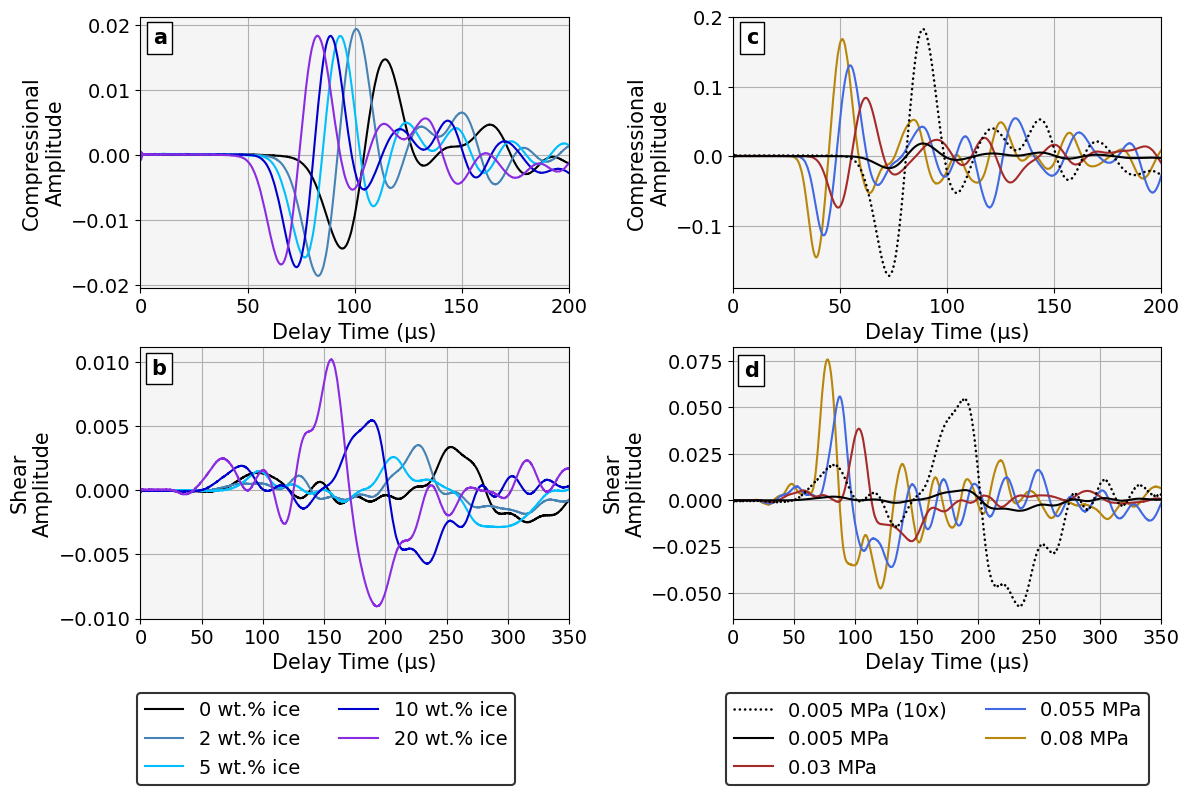

In [3]:
"""
Plot examples of raw waveforms
"""

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Data paths

p0_0i_path = "../data/raw_waves/P_waves/0_ice_granular/LightPack/16_P_0i_13-64mm_18-49g_P000_0000.asc"
p0_2i_path = "../data/raw_waves/P_waves/2_ice_granular/LightPack/6_P_2i_13-75mm_18-95g_P000_0000.asc"
p0_5i_path = "../data/raw_waves/P_waves/5_ice_granular/LightPack/10_P_5i_13-8mm_16-79g_P000_0000.asc"
p0_20i_path = "../data/raw_waves/P_waves/20_ice_granular/LightPack/18_P_20i_13-63mm_12-51g_P000_0000.asc"
p0_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_P_10i_13-9mm_16-9g_P000_0000.asc"
p1_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_2kg_P_10i_13-38mm_16-9g_P000_0000.asc"
p2_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_4kg_P_10i_13-25mm_16-9g_P000_0000.asc"
p3_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_6kg_P_10i_13-2mm_16-9g_P000_0000.asc"

s0_0i_path = "../data/raw_waves/S_waves/0_ice_granular/LightPack/8_S_0i_16-44mm_22-42g_P000_0000.asc"
s0_2i_path = "../data/raw_waves/S_waves/2_ice_granular/LightPack/8_S_2i_16-86mm_22-07g_P000_0000.asc"
s0_5i_path = "../data/raw_waves/S_waves/5_ice_granular/LightPack/2_S_5i_16-84mm_20-97g_P000_0000.asc"
s0_20i_path = "../data/raw_waves/S_waves/20_ice_granular/LightPack/3_S_20i_16-62mm_15-98g_P000_0000.asc"
s0_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_S_10i_16-9mm_19-35g_P000_0000.asc"
s1_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_2kg_S_10i_16-15mm_19-35g_P000_0000.asc"
s2_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_4kg_S_10i_16-1mm_19-35g_P000_0000.asc"
s3_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_6kg_S_10i_16-0mm_19-35g_P000_0000.asc"


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Load saved waveforms
wavep0_0i, wavep0_0i_header = rp.jsl.load_waveform(p0_0i_path, return_header=True)
wavep0_2i, wavep0_2i_header = rp.jsl.load_waveform(p0_2i_path, return_header=True)
wavep0_5i, wavep0_5i_header = rp.jsl.load_waveform(p0_5i_path, return_header=True)
wavep0_20i, wavep0_20i_header = rp.jsl.load_waveform(p0_20i_path, return_header=True)
wavep0_10i, wavep0_10i_header = rp.jsl.load_waveform(p0_10i_path, return_header=True)
wavep1_10i, wavep1_10i_header = rp.jsl.load_waveform(p1_10i_path, return_header=True)
wavep2_10i, wavep2_10i_header = rp.jsl.load_waveform(p2_10i_path, return_header=True)
wavep3_10i, wavep3_10i_header = rp.jsl.load_waveform(p3_10i_path, return_header=True)

waves0_0i, waves0_0i_header = rp.jsl.load_waveform(s0_0i_path, return_header=True)
waves0_2i, waves0_2i_header = rp.jsl.load_waveform(s0_2i_path, return_header=True)
waves0_5i, waves0_5i_header = rp.jsl.load_waveform(s0_5i_path, return_header=True)
waves0_20i, waves0_20i_header = rp.jsl.load_waveform(s0_20i_path, return_header=True)
waves0_10i, waves0_10i_header = rp.jsl.load_waveform(s0_10i_path, return_header=True)
waves1_10i, waves1_10i_header = rp.jsl.load_waveform(s1_10i_path, return_header=True)
waves2_10i, waves2_10i_header = rp.jsl.load_waveform(s2_10i_path, return_header=True)
waves3_10i, waves3_10i_header = rp.jsl.load_waveform(s3_10i_path, return_header=True)

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## P DATA
## Grab time and amplitude values

wavep0_0i_time = wavep0_0i[0,:] / 1e3
wavep0_2i_time = wavep0_2i[0,:] / 1e3
wavep0_5i_time = wavep0_5i[0,:] / 1e3
wavep0_20i_time = wavep0_20i[0,:] / 1e3
wavep0_10i_time = wavep0_10i[0,:] / 1e3
wavep1_10i_time = wavep1_10i[0,:] / 1e3
wavep2_10i_time = wavep2_10i[0,:] / 1e3
wavep3_10i_time = wavep3_10i[0,:] / 1e3
    
wavep0_0i_amp = wavep0_0i[1,:]
wavep0_2i_amp = wavep0_2i[1,:]
wavep0_5i_amp = wavep0_5i[1,:]
wavep0_20i_amp = wavep0_20i[1,:]
wavep0_10i_amp = wavep0_10i[1,:]
wavep1_10i_amp = wavep1_10i[1,:]
wavep2_10i_amp = wavep2_10i[1,:]
wavep3_10i_amp = wavep3_10i[1,:]


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## S DATA
## Grab time and amplitude values

waves0_0i_time = waves0_0i[0,:] / 1e3
waves0_2i_time = waves0_2i[0,:] / 1e3
waves0_5i_time = waves0_5i[0,:] / 1e3
waves0_20i_time = waves0_20i[0,:] / 1e3
waves0_10i_time = waves0_10i[0,:] / 1e3
waves1_10i_time = waves1_10i[0,:] / 1e3
waves2_10i_time = waves2_10i[0,:] / 1e3
waves3_10i_time = waves3_10i[0,:] / 1e3
    
waves0_0i_amp = waves0_0i[1,:]
waves0_2i_amp = waves0_2i[1,:]
waves0_5i_amp = waves0_5i[1,:]
waves0_20i_amp = waves0_20i[1,:]
waves0_10i_amp = waves0_10i[1,:]
waves1_10i_amp = waves1_10i[1,:]
waves2_10i_amp = waves2_10i[1,:]
waves3_10i_amp = waves3_10i[1,:]
    
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## PLOTS

## Plot waveforms
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
xlims_p=(0, 200)
xlims_s=(0, 350)
amp_multiplier = 10


ax[0,0].plot(wavep0_0i_time, wavep0_0i_amp, label="0 wt.% ice", color="black")
ax[0,0].plot(wavep0_2i_time, wavep0_2i_amp, label=str(round(ice_percs[0]*100))+" wt.% ice", color=ice_colors[0])
ax[0,0].plot(wavep0_5i_time, wavep0_5i_amp, label=str(round(ice_percs[1]*100))+" wt.% ice", color=ice_colors[1])
ax[0,0].plot(wavep0_10i_time, wavep0_10i_amp, label=str(round(ice_percs[2]*100))+" wt.% ice", color=ice_colors[2])
ax[0,0].plot(wavep0_20i_time, wavep0_20i_amp, label=str(round(ice_percs[3]*100))+" wt.% ice", color=ice_colors[3])
ax[0,0].grid("both")
ax[0,0].set(xlim=(xlims_p[0],xlims_p[1]),
          yscale="linear",
          facecolor="whitesmoke")
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].set_ylabel("Compressional\nAmplitude", fontsize=15)
ax[0,0].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[0,0].text(9, 0.018, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[1,0].plot(waves0_0i_time, waves0_0i_amp, label="0 wt.% ice", color="black")
ax[1,0].plot(waves0_2i_time, waves0_2i_amp, label=str(round(ice_percs[0]*100))+" wt.% ice", color=ice_colors[0])
ax[1,0].plot(waves0_5i_time, waves0_5i_amp, label=str(round(ice_percs[1]*100))+" wt.% ice", color=ice_colors[1])
ax[1,0].plot(waves0_10i_time, waves0_10i_amp, label=str(round(ice_percs[2]*100))+" wt.% ice", color=ice_colors[2])
ax[1,0].plot(waves0_20i_time, waves0_20i_amp, label=str(round(ice_percs[3]*100))+" wt.% ice", color=ice_colors[3])
ax[1,0].grid("both")
ax[1,0].set(xlim=(xlims_s[0],xlims_s[1]),
          yscale="linear",
         facecolor="whitesmoke")
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].set_ylabel("Shear\nAmplitude", fontsize=15)
ax[1,0].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[1,0].text(15, 0.0095, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
handles, labels = ax[0,0].get_legend_handles_labels()
legend1 = fig.legend(handles, labels, bbox_to_anchor=(0.11, 0.0, 1., 1), ncols=2, 
           loc='lower left', fontsize=14)
legend1.get_frame().set_linewidth(1.5)
legend1.get_frame().set_edgecolor("black")



ax[0,1].plot(wavep3_10i_time, wavep3_10i_amp, label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3])
ax[0,1].plot(wavep2_10i_time, wavep2_10i_amp, label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2])
ax[0,1].plot(wavep1_10i_time, wavep1_10i_amp, label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1])
ax[0,1].plot(wavep0_10i_time, wavep0_10i_amp, label=str(round(pressures[0]*1000,3))+" MPa", color="black")
ax[0,1].plot(wavep0_10i_time, wavep0_10i_amp*amp_multiplier, label=str(round(pressures[0]*1000,3))+" MPa", color="black", 
           ls=(0, (0.1, 2)), lw=1.8, dash_capstyle = "round")
ax[0,1].grid("both")
ax[0,1].set(xlim=(xlims_p[0],xlims_p[1]),
          yscale="linear",
          facecolor="whitesmoke")
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].set_ylabel("Compressional\nAmplitude", fontsize=15)
ax[0,1].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[0,1].text(9, 0.17, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[1,1].plot(waves3_10i_time, waves3_10i_amp, label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3])
ax[1,1].plot(waves2_10i_time, waves2_10i_amp, label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2])
ax[1,1].plot(waves1_10i_time, waves1_10i_amp, label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1])
ax[1,1].plot(waves0_10i_time, waves0_10i_amp, label=str(round(pressures[0]*1000,3))+" MPa", color="black")
ax[1,1].plot(waves0_10i_time, waves0_10i_amp*amp_multiplier, label=str(round(pressures[0]*1000,3))+" MPa (10x)", color="black", 
           ls=(0, (0.1, 2)), lw=1.8, dash_capstyle = "round")
ax[1,1].grid("both")
ax[1,1].set(xlim=(xlims_s[0],xlims_s[1]),
          yscale="linear",
         facecolor="whitesmoke")
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].set_ylabel("Shear\nAmplitude", fontsize=15)
ax[1,1].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[1,1].text(15, 0.07, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


handles, labels = ax[1,1].get_legend_handles_labels()
legend2 = fig.legend(handles[::-1], labels[::-1], bbox_to_anchor=(-0.03, 0.0, 1., 1), ncols=2, 
           loc='lower right', fontsize=14)
legend2.get_frame().set_linewidth(1.5)
legend2.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)

plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/waveforms.jpg", dpi=1000, bbox_inches = "tight")

#### TEST EPS
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/waveforms.eps", format="eps", dpi=600, bbox_inches="tight", transparent=True)

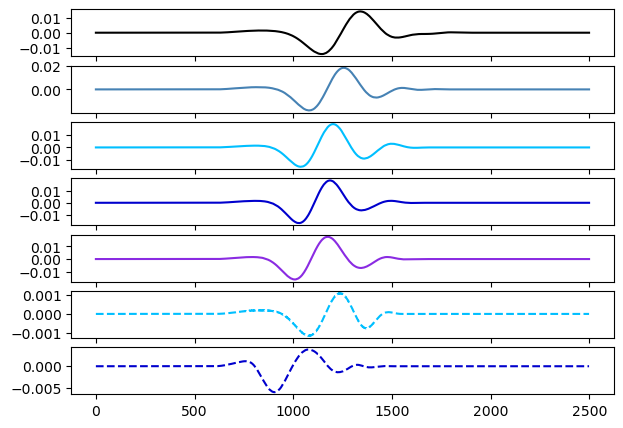

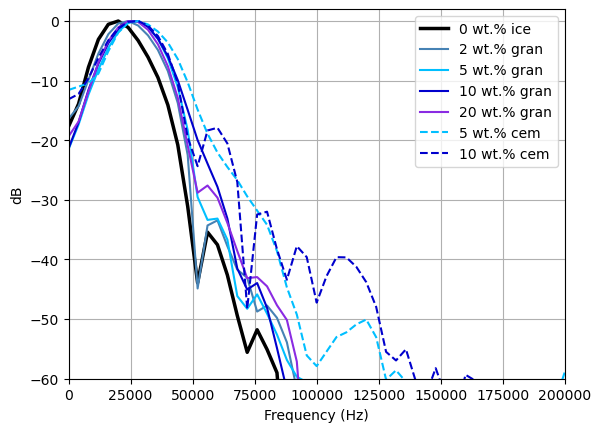

In [48]:
"""
Investigate any attenuation difference with ice content and structure
"""

## Load cemented data
p0_5icem_path = "../data/raw_waves/P_waves/5_ice_cemented/3_P_5i_25-55mm_34-14g_P000_0000.asc"
p0_10icem_path = "../data/raw_waves/P_waves/10_ice_cemented/15_P_10i_22-94mm_26-0g_P000_0000.asc"

wavep0_5icem, wavep0_5icem_header = rp.jsl.load_waveform(p0_5icem_path, return_header=True)
wavep0_10icem, wavep0_10icem_header = rp.jsl.load_waveform(p0_10icem_path, return_header=True)

wavep0_5icem_time = wavep0_5icem[0,:] / 1e3
wavep0_5icem_amp = wavep0_5icem[1,:]

wavep0_10icem_time = wavep0_10icem[0,:] / 1e3
wavep0_10icem_amp = wavep0_10icem[1,:]

sample_rate = 1 / float(wavep0_5icem_header['delta t (s)'])


## Pick time limits for FFT, making all same length
# # Single cycle
# lims_0i = (40, 135)
# lims_2i = (35-15, 135-15)
# lims_5i = (33-15, 133-20)
# lims_10i = (30-15, 130-20)
# lims_20i = (25-15, 125-20)
# lims_5icem = (15, 115-20)
# lims_10icem = (5, 105-30)

# # Two cycles
lims_0i = (40, 190-20)
lims_2i = (35, 185-30)
lims_5i = (33, 183-39)
lims_10i = (30, 180-43)
lims_20i = (25, 175-43)
lims_5icem = (15, 165-55)
lims_10icem = (5, 155-60)

# # With Coda
# lims_0i = (40, 440)
# lims_2i = (35, 435)
# lims_5i = (33, 433)
# lims_10i = (30, 430)
# lims_20i = (25, 425)
# lims_5icem = (15, 415)
# lims_10icem = (5, 405)

# # Coda only
# lims_0i = (40+90, 440+90)
# lims_2i = (35+90, 435+90)
# lims_5i = (33+90, 433+90)
# lims_10i = (30+90, 430+90)
# lims_20i = (25+90, 425+90)
# lims_5icem = (15+90, 415+90)
# lims_10icem = (5+90, 405+90)

## Define indices for trimming
lims_0i_idx = (np.abs(wavep0_0i_time-lims_0i[0]).argmin(), np.abs(wavep0_0i_time-lims_0i[1]).argmin())
lims_2i_idx = (np.abs(wavep0_2i_time-lims_2i[0]).argmin(), np.abs(wavep0_2i_time-lims_2i[1]).argmin())
lims_5i_idx = (np.abs(wavep0_5i_time-lims_5i[0]).argmin(), np.abs(wavep0_5i_time-lims_5i[1]).argmin())
lims_10i_idx = (np.abs(wavep0_10i_time-lims_10i[0]).argmin(), np.abs(wavep0_10i_time-lims_10i[1]).argmin())
lims_20i_idx = (np.abs(wavep0_20i_time-lims_20i[0]).argmin(), np.abs(wavep0_20i_time-lims_20i[1]).argmin())
lims_5icem_idx = (np.abs(wavep0_5icem_time-lims_5icem[0]).argmin(), np.abs(wavep0_5icem_time-lims_5icem[1]).argmin())
lims_10icem_idx = (np.abs(wavep0_10icem_time-lims_10icem[0]).argmin(), np.abs(wavep0_10icem_time-lims_10icem[1]).argmin())

## Trim and detrend signals
wave_0i_trim = detrend(wavep0_0i_amp[lims_0i_idx[0]:lims_0i_idx[1]])
wave_2i_trim = detrend(wavep0_2i_amp[lims_2i_idx[0]:lims_2i_idx[1]])
wave_5i_trim = detrend(wavep0_5i_amp[lims_5i_idx[0]:lims_5i_idx[1]])
wave_10i_trim = detrend(wavep0_10i_amp[lims_10i_idx[0]:lims_10i_idx[1]])
wave_20i_trim = detrend(wavep0_20i_amp[lims_20i_idx[0]:lims_20i_idx[1]])
wave_5icem_trim = detrend(wavep0_5icem_amp[lims_5icem_idx[0]:lims_5icem_idx[1]])
wave_10icem_trim = detrend(wavep0_10icem_amp[lims_10icem_idx[0]:lims_10icem_idx[1]])

## Apply taper
def apply_window(sig):
    taper_window = windows.tukey(len(sig))
    return taper_window * sig
wave_0i_trim = apply_window(wave_0i_trim)
wave_2i_trim = apply_window(wave_2i_trim)
wave_5i_trim = apply_window(wave_5i_trim)
wave_10i_trim = apply_window(wave_10i_trim)
wave_20i_trim = apply_window(wave_20i_trim)
wave_5icem_trim = apply_window(wave_5icem_trim)
wave_10icem_trim = apply_window(wave_10icem_trim)

## Add padding to make sure signals are same length
padding = max([len(wave_0i_trim), len(wave_2i_trim), len(wave_5i_trim), len(wave_10i_trim),
              len(wave_20i_trim), len(wave_5icem_trim), len(wave_10icem_trim)])
wave_0i_trim = np.pad(wave_0i_trim, (0, padding-len(wave_0i_trim)))
wave_2i_trim = np.pad(wave_2i_trim, (0, padding-len(wave_2i_trim)))
wave_5i_trim = np.pad(wave_5i_trim, (0, padding-len(wave_5i_trim)))
wave_10i_trim = np.pad(wave_10i_trim, (0, padding-len(wave_10i_trim)))
wave_20i_trim = np.pad(wave_20i_trim, (0, padding-len(wave_20i_trim)))
wave_5icem_trim = np.pad(wave_5icem_trim, (0, padding-len(wave_5icem_trim)))
wave_10icem_trim = np.pad(wave_10icem_trim, (0, padding-len(wave_10icem_trim)))

## Pad all signals
padding = 600
wave_0i_trim = np.pad(wave_0i_trim, (padding, padding))
wave_2i_trim = np.pad(wave_2i_trim, (padding, padding))
wave_5i_trim = np.pad(wave_5i_trim, (padding, padding))
wave_10i_trim = np.pad(wave_10i_trim, (padding, padding))
wave_20i_trim = np.pad(wave_20i_trim, (padding, padding))
wave_5icem_trim = np.pad(wave_5icem_trim, (padding, padding))
wave_10icem_trim = np.pad(wave_10icem_trim, (padding, padding))


## Signal Plots
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(7,5))
ax[0].plot(wave_0i_trim, color="black")
ax[1].plot(wave_2i_trim, color=ice_colors[0])
ax[2].plot(wave_5i_trim, color=ice_colors[1])
ax[3].plot(wave_10i_trim, color=ice_colors[2])
ax[4].plot(wave_20i_trim, color=ice_colors[3])
ax[5].plot(wave_5icem_trim, color=ice_colors[1], ls="--")
ax[6].plot(wave_10icem_trim, color=ice_colors[2], ls="--")
# plt.tight_layout()
plt.show()


## Compute spectra
freqs = rfftfreq(len(wave_0i_trim), 1 / sample_rate)
f_0i = rfft(wave_0i_trim)
f_2i = rfft(wave_2i_trim)
f_5i = rfft(wave_5i_trim)
f_10i = rfft(wave_10i_trim)
f_20i = rfft(wave_20i_trim)
f_5icem = rfft(wave_5icem_trim)
f_10icem = rfft(wave_10icem_trim)

# convert to normalized dB
f_0i = 20 * np.log10(np.abs(f_0i)/max(np.abs(f_0i)))
f_2i = 20 * np.log10(np.abs(f_2i)/max(np.abs(f_2i)))
f_5i = 20 * np.log10(np.abs(f_5i)/max(np.abs(f_5i)))
f_10i = 20 * np.log10(np.abs(f_10i)/max(np.abs(f_10i)))
f_20i = 20 * np.log10(np.abs(f_20i)/max(np.abs(f_20i)))
f_5icem = 20 * np.log10(np.abs(f_5icem)/max(np.abs(f_5icem)))
f_10icem = 20 * np.log10(np.abs(f_10icem)/max(np.abs(f_10icem)))

## Plot spectra
plt.figure()
plt.xlim(0, 2e5)
plt.ylim(-60, 2)
plt.plot(freqs, f_0i, label="0 wt.% ice", color="black", lw=2.5)
plt.plot(freqs, f_2i, label=str(round(ice_percs[0]*100))+" wt.% gran", color=ice_colors[0])
plt.plot(freqs, f_5i, label=str(round(ice_percs[1]*100))+" wt.% gran", color=ice_colors[1])
plt.plot(freqs, f_10i, label=str(round(ice_percs[2]*100))+" wt.% gran", color=ice_colors[2])
plt.plot(freqs, f_20i, label=str(round(ice_percs[3]*100))+" wt.% gran", color=ice_colors[3])
plt.plot(freqs, f_5icem, label=str(round(ice_percs[1]*100))+" wt.% cem", color=ice_colors[1], ls="--")
plt.plot(freqs, f_10icem, label=str(round(ice_percs[2]*100))+" wt.% cem", color=ice_colors[2], ls="--")
plt.grid("both")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.legend()
plt.show()


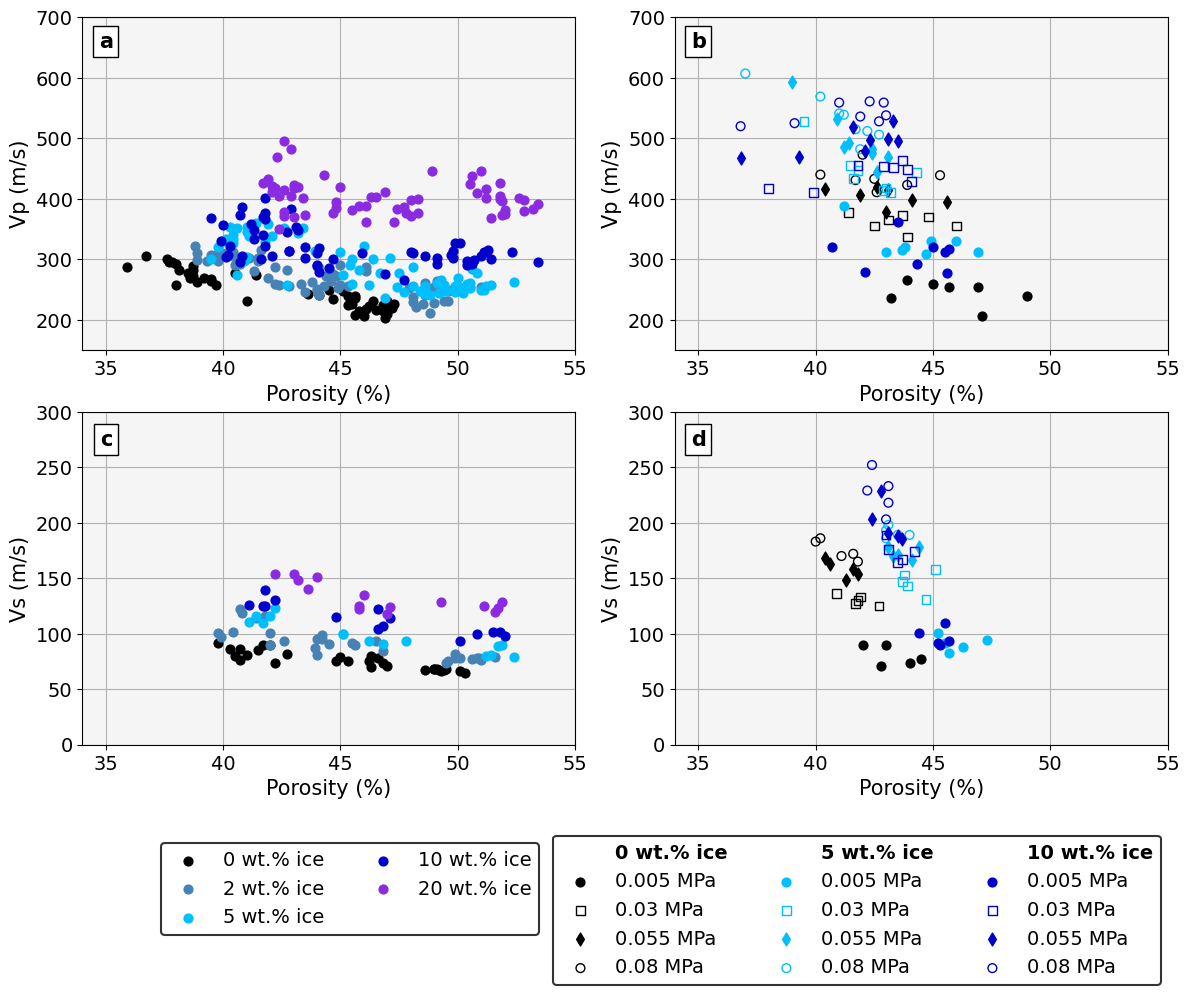

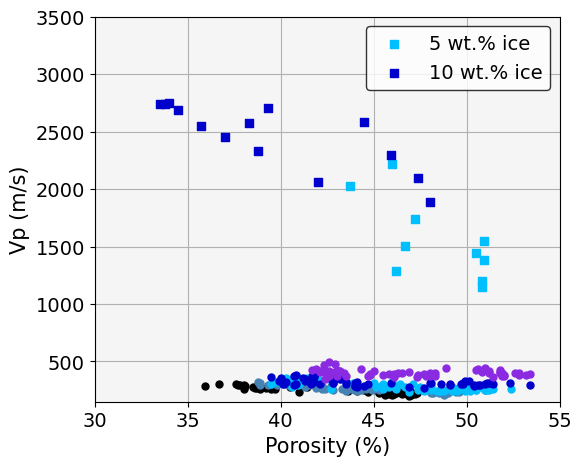

In [7]:
"""
Plot measured Vp and Vs data
"""

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
xlims = (34, 55)
dot_size = 40

ax[0,0].scatter(data_p_0i[:,2]*100, data_p_0i[:,0], s=dot_size, label="0 wt.% ice", color="black")
ax[0,0].scatter(data_p_2i[:,2]*100, data_p_2i[:,0], s=dot_size, label=str(round(ice_percs[0]*100))+" wt.% ice", 
                color=ice_colors[0])
ax[0,0].scatter(data_p_5i[:,2]*100, data_p_5i[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+" wt.% ice", 
                color=ice_colors[1])
ax[0,0].scatter(data_p_10i[:,2]*100, data_p_10i[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+" wt.% ice", 
                color=ice_colors[2])
ax[0,0].scatter(data_p_20i[:,2]*100, data_p_20i[:,0], s=dot_size, label=str(round(ice_percs[3]*100))+" wt.% ice", 
                color=ice_colors[3])
ax[0,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].set_xlabel("Porosity (%)", fontsize=15)
ax[0,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].text(35, 660, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,0].grid("both")

ax[1,0].scatter(data_s_0i[:,2]*100, data_s_0i[:,0], s=dot_size, label="0 wt.% ice", color="black")
ax[1,0].scatter(data_s_2i[:,2]*100, data_s_2i[:,0], s=dot_size, label=str(round(ice_percs[0]*100))+" wt.% ice", 
                color=ice_colors[0])
ax[1,0].scatter(data_s_5i[:,2]*100, data_s_5i[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+" wt.% ice", 
                color=ice_colors[1])
ax[1,0].scatter(data_s_10i[:,2]*100, data_s_10i[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+" wt.% ice", 
                color=ice_colors[2])
ax[1,0].scatter(data_s_20i[:,2]*100, data_s_20i[:,0], s=dot_size, label=str(round(ice_percs[3]*100))+" wt.% ice", 
                color=ice_colors[3])
ax[1,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,300),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].set_xlabel("Porosity (%)", fontsize=15)
ax[1,0].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].text(35, 275, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,0].grid("both")

handles, labels = ax[0,0].get_legend_handles_labels()
legend1 = fig.legend(handles, labels, bbox_to_anchor=(0.13, 0.05, 1., 1), ncols=2, 
           loc='lower left', fontsize=14)
legend1.get_frame().set_linewidth(1.5)
legend1.get_frame().set_edgecolor("black")


ax[0,1].scatter(pres_step_0_p_0i[:,2]*100, pres_step_0_p_0i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_p_0i[:,2]*100, pres_step_1_p_0i[:,0], s=dot_size, edgecolor="black", 
                facecolor="none", marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_p_0i[:,2]*100, pres_step_2_p_0i[:,0], s=dot_size+3, color="black", marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_p_0i[:,2]*100, pres_step_3_p_0i[:,0], s=dot_size, edgecolor="black", facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_0_p_5i[:,2]*100, pres_step_0_p_5i[:,0], s=dot_size, color=ice_colors[1],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_p_5i[:,2]*100, pres_step_1_p_5i[:,0], s=dot_size, edgecolor=ice_colors[1], 
                facecolor="none", marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_p_5i[:,2]*100, pres_step_2_p_5i[:,0], s=dot_size+3, color=ice_colors[1], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_p_5i[:,2]*100, pres_step_3_p_5i[:,0], s=dot_size, edgecolor=ice_colors[1], 
                facecolor="none", label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_0_p_10i[:,2]*100, pres_step_0_p_10i[:,0], s=dot_size, color=ice_colors[2],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_p_10i[:,2]*100, pres_step_1_p_10i[:,0], s=dot_size, edgecolor=ice_colors[2], 
                facecolor="none", marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_p_10i[:,2]*100, pres_step_2_p_10i[:,0], s=dot_size+3, color=ice_colors[2], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_p_10i[:,2]*100, pres_step_3_p_10i[:,0], s=dot_size, edgecolor=ice_colors[2], 
                facecolor="none", label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].set_xlabel("Porosity (%)", fontsize=15)
ax[0,1].set_ylabel("Vp (m/s)", fontsize=15)
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].text(35, 660, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,1].grid("both")

ax[1,1].scatter(0,0, color="none", label="0 wt.% ice")
ax[1,1].scatter(pres_step_0_s_0i[:,2]*100, pres_step_0_s_0i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_0i[:,2]*100, pres_step_1_s_0i[:,0], s=dot_size, edgecolor="black", 
                facecolor="none", marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_0i[:,2]*100, pres_step_2_s_0i[:,0], s=dot_size+3, color="black", marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_0i[:,2]*100, pres_step_3_s_0i[:,0], s=dot_size, edgecolor="black", facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[1,1].scatter(0,0, color="none", label="5 wt.% ice")
ax[1,1].scatter(pres_step_0_s_5i[:,2]*100, pres_step_0_s_5i[:,0], s=dot_size, color=ice_colors[1],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_5i[:,2]*100, pres_step_1_s_5i[:,0], s=dot_size, edgecolor=ice_colors[1], 
                facecolor="none", marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_5i[:,2]*100, pres_step_2_s_5i[:,0], s=dot_size+3, color=ice_colors[1], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_5i[:,2]*100, pres_step_3_s_5i[:,0], s=dot_size, edgecolor=ice_colors[1], 
                facecolor="none", label=str(round(pressures[3]*1000,3))+" MPa")
ax[1,1].scatter(0,0, color="none", label="10 wt.% ice")
ax[1,1].scatter(pres_step_0_s_10i[:,2]*100, pres_step_0_s_10i[:,0], s=dot_size, color=ice_colors[2],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_10i[:,2]*100, pres_step_1_s_10i[:,0], s=dot_size, edgecolor=ice_colors[2], 
                facecolor="none", marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_10i[:,2]*100, pres_step_2_s_10i[:,0], s=dot_size+3, color=ice_colors[2], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_10i[:,2]*100, pres_step_3_s_10i[:,0], s=dot_size, edgecolor=ice_colors[2], 
                facecolor="none", label=str(round(pressures[3]*1000,3))+" MPa")
ax[1,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,300),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].set_xlabel("Porosity (%)", fontsize=15)
ax[1,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].text(35, 275, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,1].grid("both")
handles, labels = ax[1,1].get_legend_handles_labels()
legend2 = fig.legend(handles, labels, bbox_to_anchor=(-0.02, 0.0, 1., 1), ncols=3, 
           loc='lower right', fontsize=14)
legend2.get_frame().set_linewidth(1.5)
legend2.get_frame().set_edgecolor("black")
for i, l in enumerate(legend2.get_texts()):
    if i in [0,5,10]:
        l.set_weight("bold")


plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/data_plot.jpg", dpi=1000, bbox_inches = "tight") 



## with cemented samples
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
dot_size = 25
xlims = (30, 55)
ax.scatter(data_p_0i[:,2]*100, data_p_0i[:,0], s=dot_size, color="black")
ax.scatter(data_p_2i[:,2]*100, data_p_2i[:,0], s=dot_size, color=ice_colors[0])
ax.scatter(data_p_5i[:,2]*100, data_p_5i[:,0], s=dot_size, color=ice_colors[1])
ax.scatter(data_p_10i[:,2]*100, data_p_10i[:,0], s=dot_size, color=ice_colors[2])
ax.scatter(data_p_20i[:,2]*100, data_p_20i[:,0], s=dot_size, color=ice_colors[3])
ax.scatter(data_p_5i_cem[:,2]*100, data_p_5i_cem[:,0], s=dot_size+10, label=str(round(ice_percs[1]*100))+" wt.% ice", 
              color=ice_colors[1], marker="s")
ax.scatter(data_p_10i_cem[:,2]*100, data_p_10i_cem[:,0], s=dot_size+10, label=str(round(ice_percs[2]*100))+" wt.% ice", 
              color=ice_colors[2], marker="s")
ax.set(xlim=(xlims[0], xlims[1]),
         ylim=(150,3500),
         axisbelow=True,
         facecolor="whitesmoke")
ax.set_xlabel("Porosity (%)", fontsize=15)
ax.set_ylabel("Vp (m/s)", fontsize=15)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14, edgecolor="black")
ax.grid("both")

plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/cemdata_plot.jpg", dpi=1000, bbox_inches = "tight") 

## Calculate an Effective Mineral and Ice Moduli

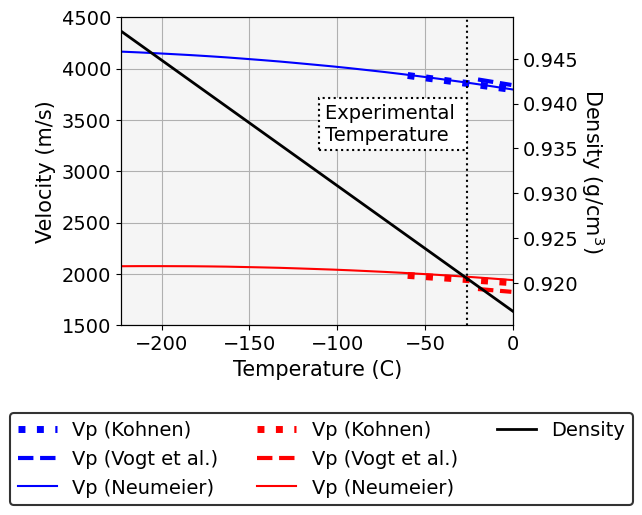

In [3]:
"""
Calculate effective mineral properties based on major 
mineral constituents of LHT-1g

Top 9 minerals were used from lab volume analysis,
representing 96.7% of total volume

k: bulk modulus, u: shear modulus
f: volume fraction, d: density
"""

## Keep this same order in the lists below
minerals = min_dict["minerals"]


## Gather mineral values into lists, use mineral order from above
min_volume_fractions = min_dict["min_volume_fractions"]
min_bulk_mods = min_dict["min_bulk_mods"]
min_shear_mods = min_dict["min_shear_mods"]
min_densities = min_dict["min_densities"]
min_pvels = [rp.elastic.p_vel(k,u,d) for k,u,d in zip(min_bulk_mods, min_shear_mods, min_densities)]
min_svels = [rp.elastic.s_vel(u,d) for u,d in zip(min_shear_mods, min_densities)]
min_vpvs = [p/s for p, s in zip(min_pvels, min_svels)]


## Calculate effective properties
## Note: difference between Hill Average and HS lower is minimal in this case
## Hill Average and HS average produce identical results
_kL, _uL = rp.bounds.hs('lower', min_volume_fractions, min_bulk_mods, min_shear_mods)
_kU, _uU = rp.bounds.hs('upper', min_volume_fractions, min_bulk_mods, min_shear_mods)
effective_mineral_k, effective_mineral_u = np.mean((_kL, _kU)), np.mean((_uL, _uU))
# eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])
eff_min_density = 2.98  ## override calculation w/ measured value
eff_min_vp = rp.elastic.p_vel(effective_mineral_k, effective_mineral_u, eff_min_density)
eff_min_vs = rp.elastic.s_vel(effective_mineral_u, eff_min_density)
eff_min_vpvs = eff_min_vp/eff_min_vs
poisson_grain = rp.elastic.poisson_mod(effective_mineral_k, effective_mineral_u)

#########################################
## Compare ice velocities presented in literature
## Calculate ice moduli at experimental temperature

def Pounder_ice_density(T):
    # from Pounder 1965, pg 114, expects temperature in C
    dens = 0.9168 * (1 - 1.53e-4 * T)
    return dens


## Velocity of ice reported by Vogt and Kohnen
temp_range_kohnen = np.arange(-60, 0, 1)
temp_range_vogt = np.arange(-20, 0, 1)
ice_vp_kohnen = [(-2.3*T + 3795) for T in temp_range_kohnen]  # from Kohnen 1974
ice_vs_kohnen = [(-1.2*T + 1915) for T in temp_range_kohnen]
ice_vp_vogt = [(3837.9 - 2.812*T) for T in temp_range_vogt]  # from Vogt 2008, used in Dou 2017
ice_vs_vogt = [(1826 - 1.425*T) for T in temp_range_vogt]

## Calculate velocity from elastic constants reported by Neumeier,
## using equations presented in Ledbetter 1977 (from Voight)
N_temp = ice_elastic_constants[:,0]
N_c11 = ice_elastic_constants[:,1]
N_c33 = ice_elastic_constants[:,2]
N_c12 = ice_elastic_constants[:,3]
N_c13 = ice_elastic_constants[:,4]
N_c44 = ice_elastic_constants[:,5]
N_c66 = 0.5*(N_c11-N_c12)  #"The Machanics of Ice", John Glen, similar to isotropic case where c66=c44

N_bulk = ((1/9) * (2*N_c11 + N_c33 + 2*N_c12 + 4*N_c13)) * 10
N_shear = ((1/15) * (2*N_c11 + N_c33 - N_c12 - 2*N_c13 + 6*N_c44 + 3*N_c66)) * 10

N_temp_C = N_temp-273
ice_density_range = Pounder_ice_density(N_temp_C)
N_vp = rp.elastic.p_vel(N_bulk, N_shear, ice_density_range)*1000
N_vs = rp.elastic.s_vel(N_shear, ice_density_range)*1000




fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

ax_dens = ax.twinx()
dens_plot = ax_dens.plot(N_temp_C, ice_density_range, color="black", lw="2", label="Density")
ax_dens.set_ylabel("Density (g/cm$^3$)", fontsize=15, rotation=270, labelpad=20)

koh_vp = ax.plot(temp_range_kohnen, ice_vp_kohnen, color="blue", ls=":",lw="5", label="Vp (Kohnen)")
vog_vp = ax.plot(temp_range_vogt, ice_vp_vogt, color="blue", ls="--",lw="3", label="Vp (Vogt et al.)")
neu_vp = ax.plot(N_temp_C, N_vp, color="blue",lw="1.5", label="Vp (Neumeier)")

koh_vs = ax.plot(temp_range_kohnen, ice_vs_kohnen, color="red", ls=":",lw="5", label="Vs (Kohnen)")
vog_vs = ax.plot(temp_range_vogt, ice_vs_vogt, color="red", ls="--",lw="3", label="Vs (Vogt et al.)")
neu_vs = ax.plot(N_temp_C, N_vs, color="red",lw="1.5", label="Vs (Neumeier)")

handles = [dens_plot[0], koh_vp[0], vog_vp[0], neu_vp[0], koh_vs[0], vog_vs[0], neu_vs[0]]

ax.set(facecolor="whitesmoke",
      axisbelow=True,
      xlim=(-223, 0),
      ylim=(1500, 4500)
      )
ax.set_xlabel("Temperature (C)", fontsize=15)
ax.set_ylabel("Velocity (m/s)", fontsize=15)
ax.tick_params(axis='both', labelsize=14)
ax_dens.tick_params(axis='both', labelsize=14)
ax.grid("both")

handles = [koh_vp[0], vog_vp[0], neu_vp[0], koh_vs[0], vog_vs[0], neu_vs[0], dens_plot[0]]
ph = [ax.plot([], marker="", ls="")[0]] * 2
handles = handles + ph
labels = ["Vp (Kohnen)", "Vp (Vogt et al.)", "Vp (Neumeier)", "Vp (Kohnen)", "Vp (Vogt et al.)", 
          "Vp (Neumeier)", "Density", "", ""]
legend = fig.legend(handles, labels, bbox_to_anchor=(0., -0.3, 1, 1), ncols=3, 
           loc='lower center', fontsize=14)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")

ax.vlines(-26, ymin=0, ymax=5000, color="black", ls=":", lw=1.5)
ax.text(-107, 3300, "Experimental \nTemperature", 
        bbox={"facecolor":"white", "alpha":1, "edgecolor":"black", 
              "linestyle":":", "linewidth":1.5},
       horizontalalignment='left', fontsize=14)

plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/iceparms_plot.jpg", dpi=1000, bbox_inches = "tight") 




ice_temp = -26  # in Celsius 
ice_dens = Pounder_ice_density(ice_temp)

## Fit Neumeier Bulk and Shear
k_fit = np.poly1d(np.polyfit(N_temp_C, N_bulk, deg=2))
u_fit = np.poly1d(np.polyfit(N_temp_C, N_shear, deg=2))

ice_k = k_fit(ice_temp)
ice_u = u_fit(ice_temp)

## Calculate moduli for grain-ice mixtures
icy_ks = []
icy_us = []
icy_dens = []
for i in ice_percs:
    v = [1-i, i]
    b = [effective_mineral_k, ice_k]
    u = [effective_mineral_u, ice_u]
    _kL, _uL = rp.bounds.hs('lower', v, b, u)
    _kU, _uU = rp.bounds.hs('upper', v, b, u)
    eff_k, eff_u = np.mean((_kL, _kU)), np.mean((_uL, _uU))
    d = sum([f*d for f, d in zip(v, [eff_min_density, ice_dens])])
    icy_ks.append(eff_k)
    icy_us.append(eff_u)
    icy_dens.append(d)

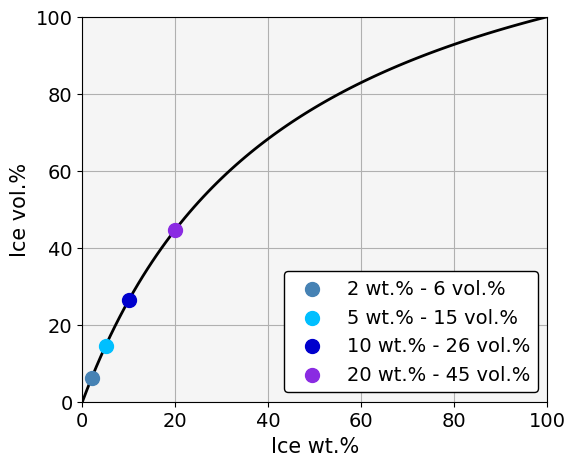

In [6]:
"""
Ice weight percent versus volume percent

All ices percents are treated as weight percent, however rock physics
models require volume percents
"""

wt_perc_ice = np.arange(0, 1.01, 0.01)
vol_perc_ice = (wt_perc_ice/ice_dens) / ((wt_perc_ice/ice_dens)+((1-wt_perc_ice)/eff_min_density))

plt.figure(figsize=(6,5))
dot_size=100
plt.plot(wt_perc_ice*100, vol_perc_ice*100, color="black", lw=2)
d0 = plt.scatter(ice_percs[0]*100, vol_perc_ice[wt_perc_ice==ice_percs[0]]*100, zorder=5, 
                 s=dot_size, color=ice_colors[0])
d1 = plt.scatter(ice_percs[1]*100, vol_perc_ice[wt_perc_ice==ice_percs[1]]*100, zorder=15, 
                 s=dot_size, color=ice_colors[1])
d2 = plt.scatter(ice_percs[2]*100, vol_perc_ice[wt_perc_ice==ice_percs[2]]*100, zorder=25, 
                 s=dot_size, color=ice_colors[2])
d3 = plt.scatter(ice_percs[3]*100, vol_perc_ice[wt_perc_ice==ice_percs[3]]*100, zorder=35, 
                 s=dot_size, color=ice_colors[3])
plt.xlabel("Ice wt.%", fontsize=15)
plt.ylabel("Ice vol.%", fontsize=15)
plt.gca().tick_params(axis='both', labelsize=14)
plt.gca().set(xlim=(0,100),
             ylim=(0,100),
             facecolor="whitesmoke")
l = plt.gca().legend([d0, d1, d2,d3], 
              ["2 wt.% - 6 vol.%",
              "5 wt.% - 15 vol.%",
              "10 wt.% - 26 vol.%",
              "20 wt.% - 45 vol.%"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, 
              fontsize=14, framealpha=1, loc="lower right",
                    edgecolor="black")
plt.grid("both")
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/ice_wt_vol.jpg", dpi=1000, bbox_inches = "tight")

## Calculate ice volume percents for later use
ice_percs_vol = [(i/ice_dens) / ((i/ice_dens)+((1-i)/eff_min_density)) for i in ice_percs]
ice_percs_vol_0_1 = [(i/ice_dens) / ((i/ice_dens)+((1-i)/eff_min_density)) for i in np.arange(0,1.01,0.01)]
ice_percs_wt_0_1 = [(i*ice_dens) / ((i*ice_dens)+((1-i)*eff_min_density)) for i in ice_percs_vol_0_1]

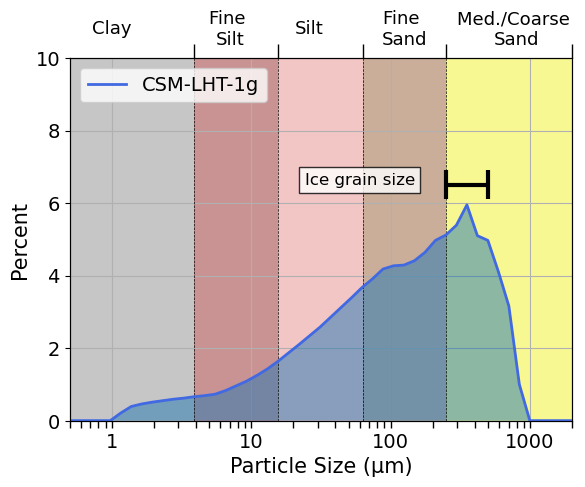

In [9]:
"""
Plot particle size distribution from LHT-1G and Ice Grains

Grain size classes shown are from the Wentworth (1922) scale.
"""

## LHT-1g
particle_sizes = particle_data[:,0]
particle_percents = particle_data[:,1]
particle_cumulative = particle_data[:,2]
particle_mean_bin = (np.abs(particle_cumulative - 50)).argmin()
particle_mean = particle_sizes[particle_mean_bin]



## From Wentworth scale, in microns
particle_boundaries=[3.9, 15.6, 63, 250, 2000, 20e3]

grain_colors = ["gray", "darkred", "lightcoral", "saddlebrown", "yellow", "lemonchiffon"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
# xlims=(2**-1, 12.5**3)
xlims=(5e-1, 2e3)
zorder = 5


## Percents bar plot
ax.plot(particle_sizes, particle_percents, color="royalblue", label="CSM-LHT-1g", linewidth=2, zorder=50)
ax.fill_between(particle_sizes, particle_percents, 0, alpha=0.5)
# bin_widths = np.pad(np.diff(particle_sizes), (0,1), mode="edge")
# bar_plot = ax[0].bar(particle_sizes, particle_percents, width=bin_widths, align="edge",
#       color="royalblue", edgecolor="black", zorder=zorder+3, label="CSM-LHT-1g")
# bar_plot[particle_mean_bin].set_color("lime")
# bar_plot[particle_mean_bin].set_edgecolor("black")
ax.set(xscale="log",
       ylim=(0, 10),
       xlim=(xlims[0], xlims[1]),
      axisbelow=True,
      facecolor="whitesmoke")
ax.set_xlabel("Particle Size (\u03BCm)", fontsize=15)
ax.set_ylabel("Percent", fontsize=15)
ax.grid(which="major")
for i, b in enumerate(particle_boundaries):
    if i==0:
        start = 0
    else:
        start = particle_boundaries[i-1]
    end = b
    ## Have to plot on `ax` to get behind bar chart
    ax.axvspan(start, end, color=grain_colors[i], alpha=0.4, zorder=-1, lw=0)
    if i != len(particle_boundaries)-1:
        ax.axvline(end, color="black", ls="--", lw=0.5)
# ax[0].xaxis.set_major_formatter(major_formatter1)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.get_xaxis().set_tick_params(which='both', size=5, width=1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc="upper left", fontsize=14)


## Grain size plot
sizeax0 = ax.twiny()
sizeax0.set(xlim=(xlims[0], xlims[1]),
          xscale="log")
sizeax0.set_xticks(ticks=particle_boundaries[:-1]) #NOTE: this MUST be called AFTER setting log scale
sizeax0.get_xaxis().set_tick_params(which='minor', size=0, width=0)
sizeax0.get_xaxis().set_tick_params(which='major', size=10, width=1)
sizeax0.text(1, 10.8, "Clay", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(7, 10.8, "Fine \nSilt", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(26, 10.8, "Silt", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(125, 10.8, "Fine \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(800, 10.8, "Med./Coarse \nSand", va="center", ha="center", rotation=0, fontsize=13)
# sizeax0.text(6000, 10.8, "Gravel", va="center", ha="center", rotation=0, fontsize=13)

# ax[0].text(2e-1, 10.8, "a", ha="center", va="center", fontweight="bold", fontsize=15,
#           bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

## Ice grain size
ax.hlines(y=6.5, xmin=250, xmax=500, color="black", lw=3)
ax.vlines(x=250, ymin=6.1, ymax=6.9, color="black", lw=3)
ax.vlines(x=500, ymin=6.1, ymax=6.9, color="black", lw=3)
ax.text(60, 6.5, "Ice grain size", 
        bbox={"facecolor":"white", "alpha":0.8, "edgecolor":"black"},
       horizontalalignment='center', fontsize=12)




plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/grain_size.jpg", dpi=1000, bbox_inches = "tight")


# Rock Physics Modeling

In [4]:
## Establish a few parameters here to keep organized

critical_porosity = 0.6  # 0.664 average from helium pyc, even higher on low-accuracy liquid pyc
fitting_por = 0.42  # fit porosity for max_poissons
max_poisson_list = [0.44, 0.426, 0.415, 0.409]  # Based on the observed average velocities
# min_poisson_list = [0.42, 0.4, 0.38, 0.37] 
contact_ratios = [0.5, 0.9, 0.9, 0.9]  # for Bachrach HM
slip_percent = 0.5  # for Bachrach HM

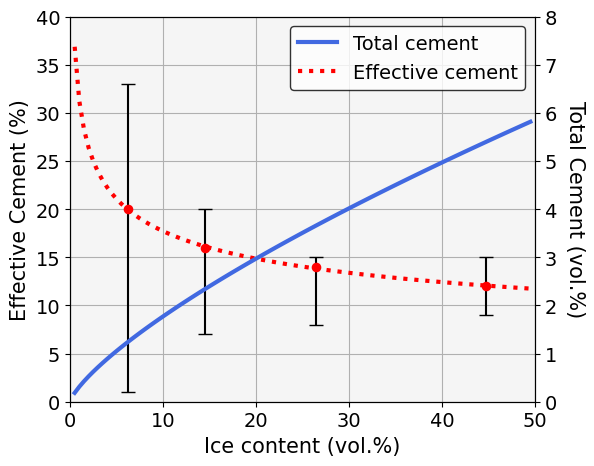

TypeError: patchy_ice_model() missing 1 required positional argument: 'ice_perc'

In [7]:
"""
Can data be explained by "effective cement",
i.e. a percentage of available ice that acts 
as cement?
"""

eff_granular_cem = [0, 0.2, 0.16, 0.14, 0.12] # current
# eff_granular_cem = [0, 0.2, 0.16, 0.12, 0.10]
eff_cemented_cem = 0.33


tmp_ice_percs_vol = [0] + ice_percs_vol
tmp_ice_percs_vol = np.array(tmp_ice_percs_vol)

por_range = np.arange(0,critical_porosity+0.01, 0.01)
max_cement = 0.1
pressure = pressures[0]
contact_ratio = contact_ratios[0]
C = 3


##------
## Use a function to adjust PR based on ice content
def pr_ice_fit(pr, ice, f=0.97):
    x_scaling = np.arange(0,1., 0.002)
    y_scaling = x_scaling**(1/4)
    y_scaling = [(i-np.amin(y_scaling))/(np.amax(y_scaling)-np.amin(y_scaling)) for i in y_scaling]
    scale_val = y_scaling[np.abs(x_scaling-ice).argmin()]
    low_val = scale_val * (pr * f)
    upper_val = (1-scale_val) * pr
    scaled_pr = low_val + upper_val

    return scaled_pr

##------
## Same PR vs pressure function as before

## Perform polynomial fit to average PR values from measurements
## Add near-intercept point to control fit
_fitpres = np.insert(pressures, 0, 0.0000001)
_fitpr = np.insert(max_poisson_list, 0, 0.49) 
pr_pres_fit = np.poly1d(np.polyfit(_fitpres**(1/10), _fitpr, deg=3))


##----------------------------------
## Create curve fit for effective cement
## per ice volume
tmp_low_vals = np.array([0.01, .07, .08, .09])
tmp_high_vals = np.array([.33, .20, .15, .15])
tmp_low_vals = np.abs(eff_granular_cem[1:]-tmp_low_vals)
tmp_high_vals = np.abs(eff_granular_cem[1:]-tmp_high_vals)
eff_cem_variance = np.array([tmp_low_vals, tmp_high_vals])

def eff_cem_fit_func(ice_vol, num, exp, bias):
    fit = num/ice_vol**exp + bias
    return fit
    
initial_guess = [0.01, 0.5, 0.1]
eff_cem_fit_parms, _ = optimize.curve_fit(eff_cem_fit_func, tmp_ice_percs_vol[1:], 
                                  eff_granular_cem[1:], p0=initial_guess)
ice_vol_range = np.arange(0.005, 0.5, 0.005)

fig, ax = plt.subplots(figsize=(6,5))
ax_tot = ax.twinx()

ax.plot(ice_vol_range*100, eff_cem_fit_func(ice_vol_range, *eff_cem_fit_parms)*100,
        color="red", ls=":", lw=3)
ax.errorbar(tmp_ice_percs_vol[1:]*100, np.array(eff_granular_cem[1:])*100,  yerr=eff_cem_variance*100, 
            fmt=".", color="black", capsize=5, markersize=1)
ax.scatter(tmp_ice_percs_vol[1:]*100, np.array(eff_granular_cem[1:])*100, color="red", s=35, zorder=100)

ax.set(xlim=(0, 50),
         ylim=(0,40),
         axisbelow=True,
         facecolor="whitesmoke")
ax.set_xlabel("Ice content (vol.%)", fontsize=15)
ax.set_ylabel("Effective Cement (%)", fontsize=15)
ax.tick_params(axis='both', labelsize=14)
ax.grid("both")

ax_tot.plot(ice_vol_range*100, eff_cem_fit_func(ice_vol_range, *eff_cem_fit_parms)*ice_vol_range*100,
        color="royalblue", lw=3, label="Total cement")
ax_tot.plot([-100, -50], [-100, -50], color="red", ls=":", lw=3, label="Effective cement")
ax_tot.set(xlim=(0, 50),
         ylim=(0,8),
          axisbelow=True)
ax_tot.tick_params(axis='both', labelsize=14)
ax_tot.set_ylabel("Total Cement (vol.%)", fontsize=15, rotation=270, labelpad=20)
ax_tot.legend(fontsize=14, edgecolor="black")

plt.show()



##----------------------------------------
##----------------------------------------
## Calculate Vp and Vs Models versus Ice Content

keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                        critical_porosity, C, pressure, 
                                        c_ratio=contact_ratio, slip_percent=slip_percent)

granular_vp, granular_vs = [], []
for ice_perc in tmp_ice_percs_vol:

    ## Adjust PR based on pressure, then adjust based on ice content
    p_pres = pr_pres_fit(pressures[0]**(1/10))
    if ice_perc == 0:
        pr = p_pres
    else:
        pr = pr_ice_fit(p_pres, ice_perc)
    
    ## DEPRECATED
    # Find fitting Poisson Ratio based on ice amount
    # pr = pr_ice_fit(ice_perc, max_poisson_list[0], min_poisson_list[0])
    # pr = pr_ice_fit(max_poisson_list[0], ice_perc)
    # pr = max_poisson_list[0]
    

    # Use function to determine effective cement
    if ice_perc == 0:
        eff_cem = 0
    else:
        eff_cem = eff_cem_fit_func(ice_perc, *eff_cem_fit_parms)
        if eff_cem > 1:
            eff_cem = 0
   

    # Account for "effective cement"
    mix_amount = ice_perc * eff_cem * 10

    vp_tmp, vs_tmp = [], []
    mix_por = critical_porosity-(mix_amount*max_cement)  # Max uncemented porosity
    for por in por_range:
        ## Only calculate up to max uncemented porosity
        if por > mix_por:
            continue
    
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="soft", mix_amount=mix_amount, ice_perc=ice_perc)

        vp_tmp.append(rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000)
        vs_tmp.append(rp.elastic.s_vel(u_patchy, d_patchy)*1000)
        
    vp_tmp, vs_tmp = np.array(vp_tmp), np.array(vs_tmp)
    granular_vp.append(vp_tmp)
    granular_vs.append(vs_tmp)

cemented_vp, cemented_vs = [], []
for ice_perc in tmp_ice_percs_vol[2:4]:

    ## For cemented case, just use constant PR since uncalibrated
    # pr = 0.3
    pr = pr_pres_fit(pressures[0]**(1/10))

    # Account for "effective cement"
    mix_amount = ice_perc * eff_cemented_cem * 10

    vp_tmp, vs_tmp = [], []
    mix_por = critical_porosity-(mix_amount*max_cement)  # Max uncemented porosity
    for por in por_range:
        ## Only calculate up to max uncemented porosity
        if por > mix_por:
            continue
    
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="stiff", mix_amount=mix_amount, ice_perc=ice_perc)

        vp_tmp.append(rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000)
        vs_tmp.append(rp.elastic.s_vel(u_patchy, d_patchy)*1000)
        
    vp_tmp, vs_tmp = np.array(vp_tmp), np.array(vs_tmp)
    cemented_vp.append(vp_tmp)
    cemented_vs.append(vs_tmp)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
dot_size = 15
ax[0,0].scatter(data_p_0i[:,2]*100, data_p_0i[:,0], s=dot_size,  color="black", zorder=50, label="0 wt.% ice")
ax[0,0].scatter(data_p_2i[:,2]*100, data_p_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50, label="2 wt.% ice")
ax[0,0].scatter(data_p_5i[:,2]*100, data_p_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50, label="5 wt.% ice")
ax[0,0].scatter(data_p_10i[:,2]*100, data_p_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50, label="10 wt.% ice")
ax[0,0].scatter(data_p_20i[:,2]*100, data_p_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50, label="20 wt.% ice")
for i, g_vp in enumerate(granular_vp):
    if i==0:
        ax[0,0].plot(por_range[:len(g_vp)]*100, g_vp, color="black")
    else:
        ax[0,0].plot(por_range[:len(g_vp)]*100, g_vp, color=ice_colors[i-1])
ax[0,0].set(xlim=(30, 60),
         ylim=(150,600),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].set_xlabel("Porosity (%)", fontsize=15)
ax[0,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].text(31.5, 575, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,0].grid("both")
ax[0,0].legend(fontsize=13, ncols=2, edgecolor="black")


ax[0,1].scatter(data_s_0i[:,2]*100, data_s_0i[:,0], s=dot_size,  color="black", zorder=50, label="0 wt.% ice")
ax[0,1].scatter(data_s_2i[:,2]*100, data_s_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50, label="2 wt.% ice")
ax[0,1].scatter(data_s_5i[:,2]*100, data_s_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50, label="5 wt.% ice")
ax[0,1].scatter(data_s_10i[:,2]*100, data_s_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50, label="10 wt.% ice")
ax[0,1].scatter(data_s_20i[:,2]*100, data_s_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50, label="20 wt.% ice")
for i, g_vs in enumerate(granular_vs):
    if i==0:
        ax[0,1].plot(por_range[:len(g_vs)]*100, g_vs, color="black")
    else:
        ax[0,1].plot(por_range[:len(g_vs)]*100, g_vs, color=ice_colors[i-1])
ax[0,1].set(xlim=(30, 60),
         ylim=(40,250),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].set_xlabel("Porosity (%)", fontsize=15)
ax[0,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].text(31.5, 238, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,1].grid("both")
ax[0,1].legend(fontsize=13, ncols=2, edgecolor="black")


ax[1,0].scatter(data_p_5i_cem[:,2]*100, data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s", zorder=50, label="5 wt.% ice")
ax[1,0].scatter(data_p_10i_cem[:,2]*100, data_p_10i_cem[:,0], s=dot_size,  
              color=ice_colors[2], marker="s", zorder=50, label="10 wt.% ice")
ax[1,0].scatter(data_p_0i[:,2]*100, data_p_0i[:,0], s=dot_size,  color="black", zorder=50, label="0 wt.% ice")
ax[1,0].plot(por_range[:len(cemented_vp[0])]*100, cemented_vp[0], color=ice_colors[1])
ax[1,0].plot(por_range[:len(cemented_vp[1])]*100, cemented_vp[1], color=ice_colors[2])
ax[1,0].plot(por_range[:len(granular_vp[0])]*100, granular_vp[0], color="black")
ax[1,0].set(xlim=(30, 60),
         ylim=(100,3500),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].set_xlabel("Porosity (%)", fontsize=15)
ax[1,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].text(31.5, 3330, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,0].grid("both")
ax[1,0].legend(fontsize=13, ncols=2, edgecolor="black")


ax[1,1].plot(por_range[:len(cemented_vs[0])]*100, cemented_vs[0], color=ice_colors[1])
ax[1,1].plot(por_range[:len(cemented_vs[1])]*100, cemented_vs[1], color=ice_colors[2])
ax[1,1].plot(por_range[:len(granular_vs[0])]*100, granular_vs[0], color="black")
ax[1,1].scatter(data_s_0i[:,2]*100, data_s_0i[:,0], s=dot_size,  color="black", zorder=50, label="0 wt.% ice")
ax[1,1].set(xlim=(30, 60),
         ylim=(0,2500),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].set_xlabel("Porosity (%)", fontsize=15)
ax[1,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].text(31.5, 2380, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,1].grid("both")
ax[1,1].legend(fontsize=13, ncols=2, edgecolor="black")

plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/meas_vs_model.jpg", dpi=1000, bbox_inches = "tight")



##----------------------------------------
##----------------------------------------
## Calculate Vp and Vs Models versus Pressure

idxs = [0,2,3]
pressure_ice_percs = [tmp_ice_percs_vol[i] for i in idxs]

granular_vp_pres, granular_vs_pres = [], []
for p in range(len(pressures)):
    pressure = pressures[p]
    contact_ratio = contact_ratios[p]

    # contact_ratio = contact_ratio*.65

    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                            critical_porosity, C, pressure, 
                                            c_ratio=contact_ratio, slip_percent=slip_percent)
    
    granular_vp, granular_vs = [], []
    for ice_perc in pressure_ice_percs:

        ## Adjust PR based on pressure, then adjust based on ice content
        p_pres = pr_pres_fit(pressures[p]**(1/10))
        if ice_perc == 0:
            pr = p_pres
        else:
            pr = pr_ice_fit(p_pres, ice_perc)


        # Use function to determine effective cement
        if ice_perc == 0:
            eff_cem = 0
        else:
            eff_cem = eff_cem_fit_func(ice_perc, *eff_cem_fit_parms)
            if eff_cem > 1:
                eff_cem = 0
    
        # Account for "effective cement"
        mix_amount = ice_perc * eff_cem * 10
        
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por_range, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="soft", mix_amount=mix_amount)
        
        vp_patchy_soft = rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000
        vs_patchy_soft = rp.elastic.s_vel(u_patchy, d_patchy)*1000
        granular_vp.append(vp_patchy_soft)
        granular_vs.append(vs_patchy_soft)
    granular_vp_pres.append(granular_vp)
    granular_vs_pres.append(granular_vs)


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,15))
dot_size=40
line_width = 2
xlims=(30, 60)
line_styles=["-", ":", "--", "-."]

ax[0,0].plot(por_range[:len(granular_vp_pres[0][0])]*100, granular_vp_pres[0][0], color=pres_colors[0],
                ls=line_styles[0], label=str(round(pressures[0]*1000,3))+" MPa", lw=line_width)
ax[0,0].scatter(pres_step_0_p_0i[:,2]*100, pres_step_0_p_0i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,0].plot(por_range[:len(granular_vp_pres[1][0])]*100, granular_vp_pres[1][0], color=pres_colors[1],
                ls=line_styles[1], label=str(round(pressures[1]*1000,3))+" MPa", lw=line_width)
ax[0,0].scatter(pres_step_1_p_0i[:,2]*100, pres_step_1_p_0i[:,0], s=dot_size, color=pres_colors[1], 
                marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,0].plot(por_range[:len(granular_vp_pres[2][0])]*100, granular_vp_pres[2][0], color=pres_colors[2],
                ls=line_styles[2], label=str(round(pressures[2]*1000,3))+" MPa", lw=line_width)
ax[0,0].scatter(pres_step_2_p_0i[:,2]*100, pres_step_2_p_0i[:,0], s=dot_size+3, color=pres_colors[2], 
             marker="d", label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,0].plot(por_range[:len(granular_vp_pres[3][0])]*100, granular_vp_pres[3][0], color=pres_colors[3],
                ls=line_styles[3], label=str(round(pressures[3]*1000,3))+" MPa", lw=line_width)
ax[0,0].scatter(pres_step_3_p_0i[:,2]*100, pres_step_3_p_0i[:,0], s=dot_size, color=pres_colors[3],
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].set_xlabel("Porosity (%)", fontsize=15)
ax[0,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].text(32, 660, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,0].text(53, 660, "0 wt.% ice", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"whitesmoke", "alpha":1, "edgecolor":"black", "boxstyle":"round"})
ax[0,0].grid("both")


ax[0,1].scatter(pres_step_0_s_0i[:,2]*100, pres_step_0_s_0i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_s_0i[:,2]*100, pres_step_1_s_0i[:,0], s=dot_size, color=pres_colors[1], 
                marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_s_0i[:,2]*100, pres_step_2_s_0i[:,0], s=dot_size+3, color=pres_colors[2], 
             marker="d", label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_s_0i[:,2]*100, pres_step_3_s_0i[:,0], s=dot_size, color=pres_colors[3],
             label=str(round(pressures[3]*1000,3))+" MPa")
for i in range(len(granular_vs_pres)):
    ax[0,1].plot(por_range[:len(granular_vs_pres[i][0])]*100, granular_vs_pres[i][0], color=pres_colors[i],
                ls=line_styles[i], lw=line_width)
ax[0,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,350),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].set_xlabel("Porosity (%)", fontsize=15)
ax[0,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].text(32, 325, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,1].text(53, 325, "0 wt.% ice", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"whitesmoke", "alpha":1, "edgecolor":"black", "boxstyle":"round"})
ax[0,1].grid("both")



ax[1,0].scatter(pres_step_0_p_5i[:,2]*100, pres_step_0_p_5i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,0].scatter(pres_step_1_p_5i[:,2]*100, pres_step_1_p_5i[:,0], s=dot_size, color=pres_colors[1], 
                marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,0].scatter(pres_step_2_p_5i[:,2]*100, pres_step_2_p_5i[:,0], s=dot_size+3, color=pres_colors[2], 
             marker="d", label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,0].scatter(pres_step_3_p_5i[:,2]*100, pres_step_3_p_5i[:,0], s=dot_size, color=pres_colors[3], 
                label=str(round(pressures[3]*1000,3))+" MPa")
for i in range(len(granular_vp_pres)):
    ax[1,0].plot(por_range[:len(granular_vp_pres[i][1])]*100, granular_vp_pres[i][1], color=pres_colors[i],
                ls=line_styles[i], lw=line_width)
ax[1,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].set_xlabel("Porosity (%)", fontsize=15)
ax[1,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].text(32, 660, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,0].text(53, 660, "5 wt.% ice", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"whitesmoke", "alpha":1, "edgecolor":"black", "boxstyle":"round"})
ax[1,0].grid("both")


ax[1,1].scatter(pres_step_0_s_5i[:,2]*100, pres_step_0_s_5i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_5i[:,2]*100, pres_step_1_s_5i[:,0], s=dot_size, color=pres_colors[1], 
                marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_5i[:,2]*100, pres_step_2_s_5i[:,0], s=dot_size+3, color=pres_colors[2],
              marker="d", label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_5i[:,2]*100, pres_step_3_s_5i[:,0], s=dot_size, color=pres_colors[3], 
                label=str(round(pressures[3]*1000,3))+" MPa")
for i in range(len(granular_vs_pres)):
    ax[1,1].plot(por_range[:len(granular_vs_pres[i][1])]*100, granular_vs_pres[i][1], color=pres_colors[i],
                ls=line_styles[i], lw=line_width)
ax[1,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,350),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].set_xlabel("Porosity (%)", fontsize=15)
ax[1,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].text(32, 325, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,1].text(53, 325, "5 wt.% ice", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"whitesmoke", "alpha":1, "edgecolor":"black", "boxstyle":"round"})
ax[1,1].grid("both")



ax[2,0].scatter(pres_step_0_p_10i[:,2]*100, pres_step_0_p_10i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[2,0].scatter(pres_step_1_p_10i[:,2]*100, pres_step_1_p_10i[:,0], s=dot_size, color=pres_colors[1], 
                marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[2,0].scatter(pres_step_2_p_10i[:,2]*100, pres_step_2_p_10i[:,0], s=dot_size+3, color=pres_colors[2], 
             marker="d", label=str(round(pressures[2]*1000,3))+" MPa")
ax[2,0].scatter(pres_step_3_p_10i[:,2]*100, pres_step_3_p_10i[:,0], s=dot_size, color=pres_colors[3], 
                label=str(round(pressures[3]*1000,3))+" MPa")
for i in range(len(granular_vp_pres)):
    ax[2,0].plot(por_range[:len(granular_vp_pres[i][2])]*100, granular_vp_pres[i][2], color=pres_colors[i],
                ls=line_styles[i], lw=line_width)
ax[2,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[2,0].set_xlabel("Porosity (%)", fontsize=15)
ax[2,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[2,0].tick_params(axis='both', labelsize=14)
ax[2,0].text(32, 660, "e", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[2,0].text(53, 660, "10 wt.% ice", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"whitesmoke", "alpha":1, "edgecolor":"black", "boxstyle":"round"})
ax[2,0].grid("both")


ax[2,1].scatter(pres_step_0_s_10i[:,2]*100, pres_step_0_s_10i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[2,1].scatter(pres_step_1_s_10i[:,2]*100, pres_step_1_s_10i[:,0], s=dot_size, color=pres_colors[1], 
                marker="s", label=str(round(pressures[1]*1000,3))+" MPa")
ax[2,1].scatter(pres_step_2_s_10i[:,2]*100, pres_step_2_s_10i[:,0], s=dot_size+3, color=pres_colors[2], 
             marker="d", label=str(round(pressures[2]*1000,3))+" MPa")
ax[2,1].scatter(pres_step_3_s_10i[:,2]*100, pres_step_3_s_10i[:,0], s=dot_size, color=pres_colors[3], 
                label=str(round(pressures[3]*1000,3))+" MPa")
for i in range(len(granular_vs_pres)):
    ax[2,1].plot(por_range[:len(granular_vs_pres[i][2])]*100, granular_vs_pres[i][2], color=pres_colors[i],
                ls=line_styles[i], lw=line_width)
ax[2,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,350),
         axisbelow=True,
         facecolor="whitesmoke")
ax[2,1].set_xlabel("Porosity (%)", fontsize=15)
ax[2,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[2,1].tick_params(axis='both', labelsize=14)
ax[2,1].text(32, 325, "f", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[2,1].text(53, 325, "10 wt.% ice", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"whitesmoke", "alpha":1, "edgecolor":"black", "boxstyle":"round"})
ax[2,1].grid("both")

h, l = ax[0,0].get_legend_handles_labels()
ph = [ax[0,0].plot([], marker="", ls="")[0]] * 2
handles = ph + h

labels = ["Modeled:", "Measured:"] + l
legend = fig.legend(handles, labels, bbox_to_anchor=(0.02, 0.0, 1., 1), ncols=5, 
           loc='lower center', fontsize=15)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")


plt.tight_layout()
plt.subplots_adjust(bottom=0.11)
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/pres_meas_vs_model.jpg", dpi=1000, bbox_inches = "tight")

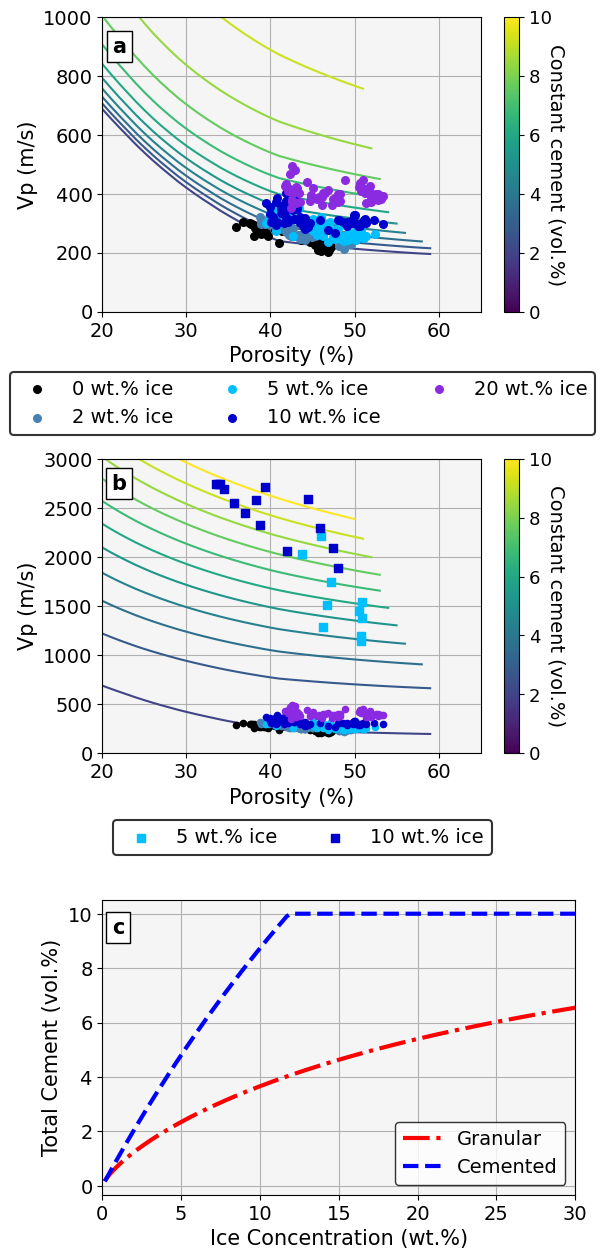

In [17]:
"""
Illustrate how effective cement was determined
"""

por_range = np.arange(0,critical_porosity, 0.01)
max_cement = 0.1
pressure = pressures[0]
contact_ratio = contact_ratios[0]
max_poisson = max_poisson_list[0]
C = 3

keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)

mixes = np.arange(0, 1.01, 0.1)
stiff_mixes_vp, stiff_mixes_vs = [], []
soft_mixes_vp, soft_mixes_vs = [], []

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,15))
dot_size = 30
n_colors = len(mixes)
plot_colors = plt.cm.viridis(np.linspace(0.2,1,n_colors))
cmap = plt.get_cmap("viridis")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=10))


for m, mix_amount in enumerate(mixes):
    vp_tmp, vs_tmp = [], []
    mix_por = critical_porosity-(mix_amount*max_cement)  # Max uncemented porosity
    for por in por_range:
        ## Only calculate up to max uncemented porosity
        if por > mix_por:
            continue
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain = eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=max_poisson,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="stiff", mix_amount=mix_amount)
    
        vp_tmp.append(rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000)
        vs_tmp.append(rp.elastic.s_vel(u_patchy, d_patchy)*1000)
        
    vp_tmp, vs_tmp = np.array(vp_tmp), np.array(vs_tmp)
    stiff_mixes_vp.append(vp_tmp)
    stiff_mixes_vs.append(vs_tmp)

    ## Stiff Vpplot
    ax[1].plot(por_range[:len(vp_tmp)]*100, vp_tmp, color=plot_colors[m])

    vp_tmp, vs_tmp = [], []
    for por in por_range:
        ## Only calculate up to max uncemented porosity
        if por > mix_por:
            continue
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain = eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=max_poisson,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="soft", mix_amount=mix_amount)
        
        vp_tmp.append(rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000)
        vs_tmp.append(rp.elastic.s_vel(u_patchy, d_patchy)*1000)

    vp_tmp, vs_tmp = np.array(vp_tmp), np.array(vs_tmp)
    soft_mixes_vp.append(vp_tmp)
    soft_mixes_vs.append(vs_tmp)

    ## Soft Vp plot
    ax[0].plot(por_range[:len(vp_tmp)]*100, vp_tmp, color=plot_colors[m])
    

## Plot data points
ax[0].scatter(data_p_5i_cem[:,2]*100, data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s", zorder=50)
ax[0].scatter(data_p_10i_cem[:,2]*100, data_p_10i_cem[:,0], s=dot_size,  
              color=ice_colors[2], marker="s", zorder=50)
ax[0].scatter(data_p_0i[:,2]*100, data_p_0i[:,0], s=dot_size,  color="black", zorder=50,
             label="0 wt.% ice")
ax[0].scatter(data_p_2i[:,2]*100, data_p_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50,
             label="2 wt.% ice")
ax[0].scatter(data_p_5i[:,2]*100, data_p_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50,
             label="5 wt.% ice")
ax[0].scatter(data_p_10i[:,2]*100, data_p_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50,
             label="10 wt.% ice")
ax[0].scatter(data_p_20i[:,2]*100, data_p_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50,
             label="20 wt.% ice")
ax[0].set(ylim=(0,1000),
         xlim=(20, 65),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_xlabel("Porosity (%)", fontsize=15)
ax[0].set_ylabel("Vp (m/s)", fontsize=15)
ax[0].grid("both")
cbar0 = plt.colorbar(sm, ax=ax[0])
cbar0.set_label("Constant cement (vol.%)", rotation=270, fontsize=14, labelpad=10)
cbar0.ax.tick_params(labelsize=13)
handles, labels = ax[0].get_legend_handles_labels()
legend0 = fig.legend(handles, labels, bbox_to_anchor=(0., 0.7, 1., 1), ncols=3, 
           loc='lower center', fontsize=14)
legend0.get_frame().set_linewidth(1.5)
legend0.get_frame().set_edgecolor("black")
ax[0].text(22, 900, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


ax[1].scatter(data_p_5i_cem[:,2]*100, data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s", zorder=50, label="5 wt.% ice")
ax[1].scatter(data_p_10i_cem[:,2]*100, data_p_10i_cem[:,0], s=dot_size,  
              color=ice_colors[2], marker="s", zorder=50, label="10 wt.% ice")
ax[1].scatter(data_p_0i[:,2]*100, data_p_0i[:,0], s=dot_size-10,  color="black", zorder=50)
ax[1].scatter(data_p_2i[:,2]*100, data_p_2i[:,0], s=dot_size-10, color=ice_colors[0], zorder=50)
ax[1].scatter(data_p_5i[:,2]*100, data_p_5i[:,0], s=dot_size-10, color=ice_colors[1], zorder=50)
ax[1].scatter(data_p_10i[:,2]*100, data_p_10i[:,0], s=dot_size-10, color=ice_colors[2], zorder=50)
ax[1].scatter(data_p_20i[:,2]*100, data_p_20i[:,0], s=dot_size-10, color=ice_colors[3], zorder=50)
ax[1].set(ylim=(0,3000),
         xlim=(20, 65),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].tick_params(axis='both', labelsize=14)
ax[1].set_xlabel("Porosity (%)", fontsize=15)
ax[1].set_ylabel("Vp (m/s)", fontsize=15)
ax[1].grid("both")
cbar1 = plt.colorbar(sm, ax=ax[1])
cbar1.set_label("Constant cement (vol.%)", rotation=270, fontsize=14, labelpad=10)
cbar1.ax.tick_params(labelsize=13)
handles, labels = ax[1].get_legend_handles_labels()
legend1 = fig.legend(handles, labels, bbox_to_anchor=(0, 0.42, 1., 1), ncols=2, 
           loc='lower center', fontsize=14)
legend1.get_frame().set_linewidth(1.5)
legend1.get_frame().set_edgecolor("black")
ax[1].text(22, 2750, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


ice_vol_range = np.arange(0.005, 1., 0.005)
plot_cement = ice_vol_range*eff_cemented_cem
plot_cement = np.where(plot_cement>.1, .1, plot_cement)
plot_granular = eff_cem_fit_func(ice_vol_range, *eff_cem_fit_parms)*ice_vol_range
plot_granular = np.where(plot_granular>.1, .1, plot_granular)
plot_wt_range = np.array([(i*ice_dens) / ((i*ice_dens)+((1-i)*eff_min_density)) for i in ice_vol_range])

ax[2].plot(plot_wt_range*100, plot_granular*100,
        color="red", ls="-.", lw=3, label="Granular")
ax[2].plot(plot_wt_range*100, plot_cement*100,
        color="blue", ls="--", lw=3, label="Cemented")
ax[2].set(xlim=(0, 30),
         # ylim=(0,0.08),
         axisbelow=True,
         facecolor="whitesmoke")
ax[2].set_xlabel("Ice Concentration (wt.%)", fontsize=15)
ax[2].set_ylabel("Total Cement (vol.%)", fontsize=15)
ax[2].tick_params(axis='both', labelsize=14)
ax[2].legend(fontsize=14, loc="lower right", edgecolor="black")
ax[2].grid("both")
ax[2].text(1, 9.5, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.2)
plt.show()

# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/cement_determination.jpg", dpi=1000, bbox_inches = "tight")

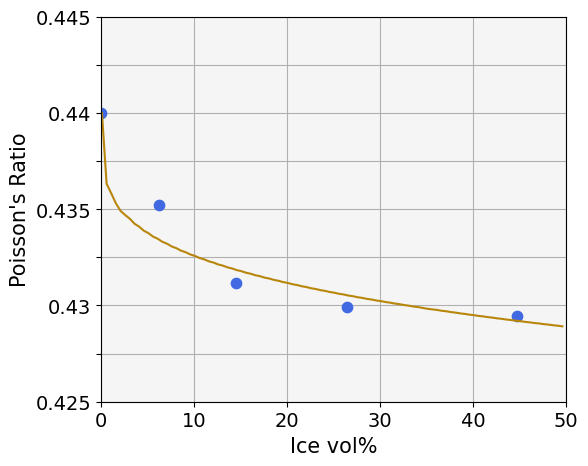

In [7]:
"""
Illustrate the PR vs Ice relationship
"""

## These values were manually determined from the 0.005 MPa data
fit_vp_p0 = [310, 345, 385, 455]
fit_vs_p0 = [105, 120, 135, 160]

# fit_vp_p0 = [300, 335, 375, 440]
# fit_vs_p0 = [105, 120, 135, 160]

tmp_prs = [rp.elastic.poisson_vel(p, s) for p, s in zip(fit_vp_p0, fit_vs_p0)]

tmp_ice_range = np.arange(0.001, 0.5, 0.005)

calc_prs = []
for ice in tmp_ice_range:
    calc_prs.append(pr_ice_fit(max_poisson_list[0], ice))




plt.figure(figsize=(6,5))
dot_size=55

plt.plot(tmp_ice_range*100, calc_prs, color="darkgoldenrod")
plt.scatter(0, max_poisson_list[0], c="royalblue", s=dot_size)
plt.scatter(np.array(ice_percs_vol)*100, tmp_prs, c="royalblue", s=dot_size)
plt.xlabel("Ice vol.%", fontsize=15)
plt.ylabel("Poisson's Ratio", fontsize=15)
plt.gca().tick_params(axis='both', labelsize=14)
plt.gca().set(xlim=(0,50),
             ylim=(0.425,0.445),
             facecolor="whitesmoke",
             axisbelow=True)
for label in plt.gca().yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.gca().yaxis.set_major_formatter(major_formatter3)

plt.grid("both")
plt.show()

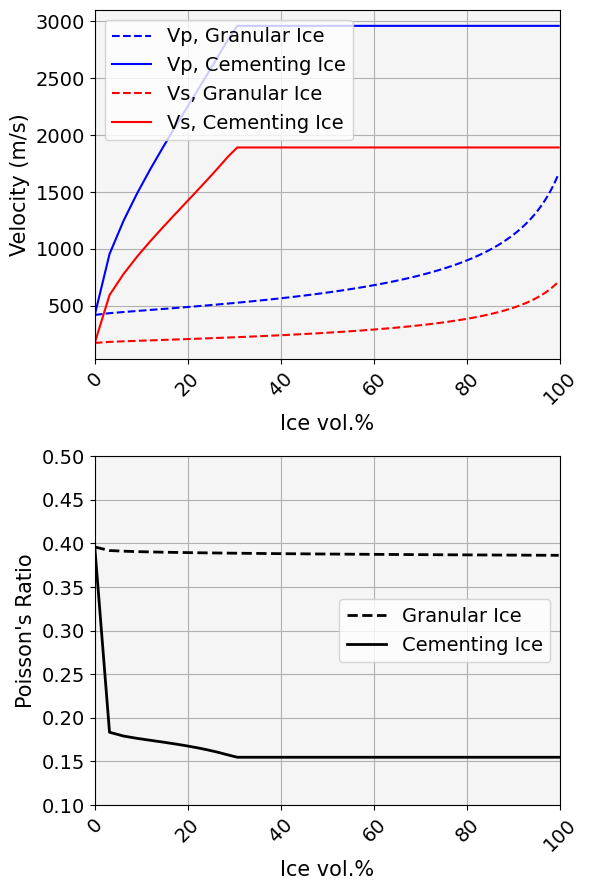

In [33]:
"""
Show velocity vs ice concentration at constant pressure/porosity
"""

plot_por = 0.3
pressure = pressures[0]
contact_ratio = contact_ratios[0]
max_cement = 0.1
# plot_ice_percs_wt = np.arange(0, 0.11, 0.005)
plot_ice_percs_wt = np.arange(0, 1., 0.01)
plot_ice_percs_vol = np.array([(i/ice_dens) / ((i/ice_dens)+((1-i)/eff_min_density)) for i in plot_ice_percs_wt])

keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                        critical_porosity, C, pressure, 
                                        c_ratio=contact_ratio, slip_percent=slip_percent)

granular_vp, granular_vs = [], []
for ice_perc in plot_ice_percs_vol:

    ## Adjust PR based on pressure, then adjust based on ice content
    p_pres = pr_pres_fit(pressures[0]**(1/10))
    if ice_perc == 0:
        pr = p_pres
    else:
        pr = pr_ice_fit(p_pres, ice_perc)
    
    ## DEPRECATED
    # Find fitting Poisson Ratio based on ice amount
    # pr = pr_ice_fit(ice_perc, max_poisson_list[0], min_poisson_list[0])
    # pr = pr_ice_fit(max_poisson_list[0], ice_perc)
    # pr = max_poisson_list[0]
    

    # Use function to determine effective cement
    if ice_perc == 0:
        eff_cem = 0
    else:
        eff_cem = eff_cem_fit_func(ice_perc, *eff_cem_fit_parms)
        if eff_cem > 1:
            eff_cem = 0

    # Account for "effective cement"
    mix_amount = ice_perc * eff_cem * 10
    
    k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                         por=plot_por, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="soft", mix_amount=mix_amount)
    
    vp_patchy_soft = rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000
    vs_patchy_soft = rp.elastic.s_vel(u_patchy, d_patchy)*1000
    granular_vp.append(vp_patchy_soft)
    granular_vs.append(vs_patchy_soft)

cemented_vp, cemented_vs = [], []
for ice_perc in plot_ice_percs_vol:

    if ice_perc == 0:
        pr = pr_pres_fit(pressures[0]**(1/10))
    else:  ## pr doesn't get used with non-zero ice content in cemented model
        pr = 0

    # Account for "effective cement"
    mix_amount = ice_perc * eff_cemented_cem * 10
    if mix_amount > 1.:
        mix_amount = 1.
    
    k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                         por=plot_por, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="stiff", mix_amount=mix_amount)
    
    vp_patchy_stiff = rp.elastic.p_vel(k_patchy, u_patchy, d_patchy)*1000
    vs_patchy_stiff = rp.elastic.s_vel(u_patchy, d_patchy)*1000
    cemented_vp.append(vp_patchy_stiff)
    cemented_vs.append(vs_patchy_stiff)


granular_vp, granular_vs = np.array(granular_vp), np.array(granular_vs)
granular_vpvs = granular_vp/granular_vs
granular_pr = rp.elastic.poisson_vel(granular_vp, granular_vs)
cemented_vp, cemented_vs = np.array(cemented_vp), np.array(cemented_vs)
cemented_vpvs = cemented_vp/cemented_vs
cemented_pr = rp.elastic.poisson_vel(cemented_vp, cemented_vs)


## Single plot
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
# xlims = (0, 100)
# gran_ls = "--"
# cem_ls = "-"
# ax.plot(plot_ice_percs_wt*100, granular_vp, ls=gran_ls, color="blue", label="Vp, Granular Ice")
# ax.plot(plot_ice_percs_wt*100, cemented_vp, ls=cem_ls, color="blue", label="Vp, Cementing Ice")
# ax.plot(plot_ice_percs_wt*100, granular_vs, ls=gran_ls, color="red", label="Vs, Granular Ice")
# ax.plot(plot_ice_percs_wt*100, cemented_vs, ls=cem_ls, color="red", label="Vs, Cementing Ice")
# ax.set(xlim=(xlims[0], xlims[1]),
#           # ylim=(0,2700),
#            facecolor="whitesmoke",
#            axisbelow=True)
# ax.set_xlabel("Ice wt.%", fontsize=15)
# ax.set_ylabel("Velocity (m/s)", fontsize=15)
# ax.tick_params(axis='both', labelsize=14)
# ax.tick_params(axis='x', rotation=45)
# ax.grid("both")
# ax.legend(fontsize=14)
# plt.tight_layout()
# plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/vp_vs_ice.jpg", dpi=1000, bbox_inches = "tight")



## Double plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,9))
xlims = (0, 100)
gran_ls = "--"
cem_ls = "-"

ax[0].plot(plot_ice_percs_vol*100, granular_vp, ls=gran_ls, color="blue", label="Vp, Granular Ice")
ax[0].plot(plot_ice_percs_vol*100, cemented_vp, ls=cem_ls, color="blue", label="Vp, Cementing Ice")
ax[0].plot(plot_ice_percs_vol*100, granular_vs, ls=gran_ls, color="red", label="Vs, Granular Ice")
ax[0].plot(plot_ice_percs_vol*100, cemented_vs, ls=cem_ls, color="red", label="Vs, Cementing Ice")
ax[0].set(xlim=(xlims[0], xlims[1]),
          # ylim=(0,2700),
           facecolor="whitesmoke",
           axisbelow=True)
ax[0].set_xlabel("Ice vol.%", fontsize=15)
ax[0].set_ylabel("Velocity (m/s)", fontsize=15)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid("both")
ax[0].legend(fontsize=14)


ax[1].plot(plot_ice_percs_vol*100, granular_pr, ls=gran_ls, color="black", label="Granular Ice", lw=2)
ax[1].plot(plot_ice_percs_vol*100, cemented_pr, ls=cem_ls, color="black", label="Cementing Ice", lw=2)
ax[1].set(xlim=(xlims[0], xlims[1]),
          ylim=(0.1, 0.5),
           facecolor="whitesmoke",
           axisbelow=True)
ax[1].set_xlabel("Ice vol.%", fontsize=15)
ax[1].set_ylabel("Poisson's Ratio", fontsize=15)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid("both")
ax[1].legend(loc="center right", fontsize=14)

plt.tight_layout()
plt.show()

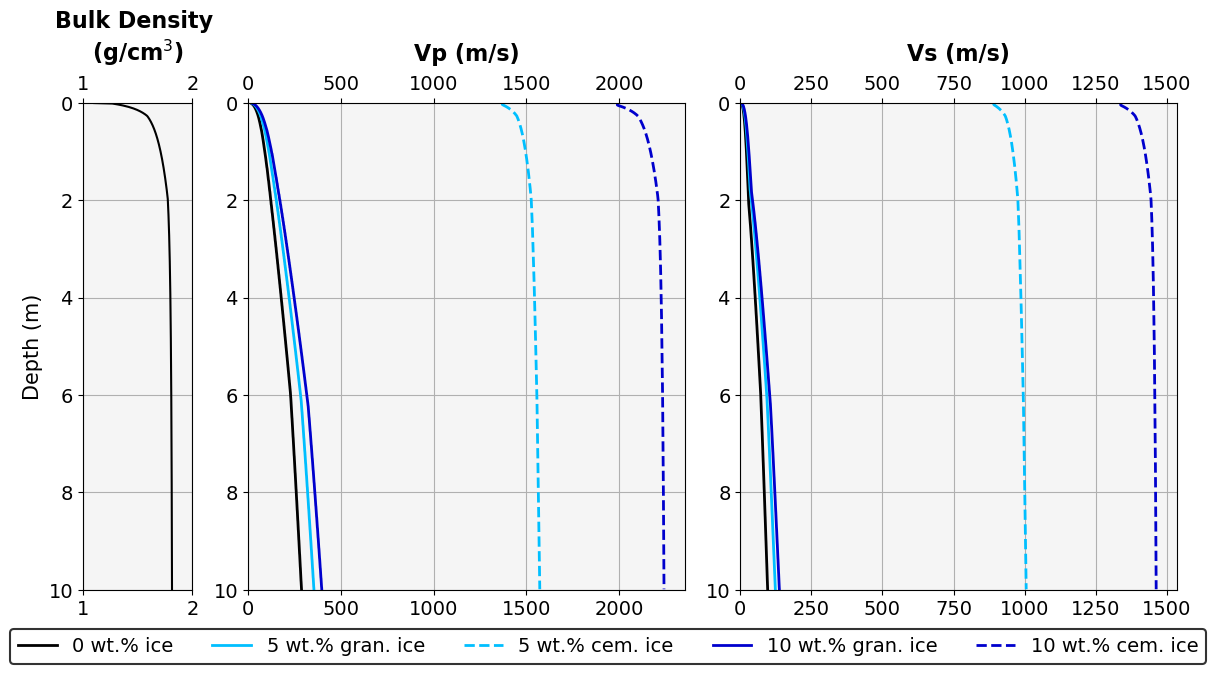

In [19]:
"""
Create 1D velocity models 

CONSIDERATIONS TO FOLLOW UP
-should ice be pore-filling? my measurements don't jive with that
-looks like porosity is increased by ~3% at 20 wt% ice

"""

##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES

## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Specific gravity of regolith
sg_low = 2.9
sg_high = 3.24

## Depth range, in m
max_depth = 10
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equations from Lunar Sourcebook, in g/cm3, page 494
## Assume 5% error for lows and highs calculations
dens_err = 0.05
densities_hyp = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))   #hyperbolic function
densities_pow = 1.39*(depths*100)**0.056
dens_stk = np.vstack((densities_hyp, densities_pow))
dens_low = np.amin(dens_stk, axis=0) * (1-dens_err)

## Calculate porosity low and high
por_high = 1 - (dens_low / sg_high)


## Pressure, in MPa
integrated_density_low = integrate.cumulative_trapezoid(dens_low)
ss_pressures_low = np.cumsum((grav_accel * integrated_density_low * depth_step) / 1e6)
ss_pressures_low = np.hstack((0, ss_pressures_low))


##---------------
## Make icy 1D profiles

## Porosity increase due to granular ice
_por_inc = [0, 0.03]
_ice_perc = [0, ice_percs_vol[-1]]
ice_por_inc_fit = np.poly1d(np.polyfit(_ice_perc, _por_inc, deg=1))

## Ice profile
ice_amts = [0, ice_percs_vol[1], ice_percs_vol[2]]
ice_amts_wt = [0, ice_percs[1], ice_percs[2]]


vp_amos_gran, vs_amos_gran = [], []
vp_amos_cem, vs_amos_cem = [], []
density_profs = []
for ice_amt in ice_amts:

    ## Make ice profile
    ice_profile = np.full(depths.shape, ice_amt)
    por_inc = ice_por_inc_fit(ice_profile)

    ## Icy density profiles
    ## Just assume reg density of 3 and ice 0.92
    dens_diff = 0.92/3
    ice_sg_high = 3.24 - (dens_diff*ice_amt*3.24)
    ice_dens_low = dens_low - (dens_diff*ice_amt*dens_low)
    min_dens = ice_sg_high * (1 - 0.66 + por_inc[0])
    ice_dens_low = np.clip(ice_dens_low, a_min=min_dens, a_max=None)
    density_profs.append(ice_dens_low)

    ## Calculate porosity
    ice_por_high = (1 - (ice_dens_low / ice_sg_high)) + por_inc
    
    ## Pressure, in MPa
    ice_integrated_density_low = integrate.cumulative_trapezoid(ice_dens_low)
    ice_ss_pressures_low = np.cumsum((grav_accel * ice_integrated_density_low * depth_step) / 1e6)
    ice_ss_pressures_low = np.hstack((0, ice_ss_pressures_low))

    gran_vp_tmp, gran_vs_tmp = [], []
    cem_vp_tmp, cem_vs_tmp = [], []
    for por, pressure, ice_perc in zip(ice_por_high, ice_ss_pressures_low, ice_profile):
        
        if pressure==0:
            continue
        ## Change pressure to GPa
        pressure = pressure/1000

        if por > critical_porosity:
            por = critical_porosity
    
        C = 3
    
        ## Adjust PR based on pressure, then adjust based on ice content
        p_pres = pr_pres_fit(pressure**(1/10))
        if ice_perc == 0:
            pr = p_pres
        else:
            pr = pr_ice_fit(p_pres, ice_perc)
    

        ## Estimate a contact ratio based on pressure
        if pressure <= pressures[0]:
            tmp_p_range = np.linspace(0, pressures[0], 100)
            tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
            tmp_cr_range = np.linspace(0.1, contact_ratios[0], 100) #0.4 used to be 0.25
            contact_ratio = tmp_cr_range[tmp_p_idx]
        elif pressures[0] < pressure <= pressures[1]:
            tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
            tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
            tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
            contact_ratio = tmp_cr_range[tmp_p_idx]
        else:
            contact_ratio = contact_ratios[-1]
    
        keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                                critical_porosity, C, pressure, 
                                                c_ratio=contact_ratio, slip_percent=slip_percent)

        ## GRANULAR
        ## Account for "effective cement"
        ## Use function to determine effective cement for granular
        if ice_perc == 0:
            eff_cem = 0
        else:
            eff_cem = eff_cem_fit_func(ice_perc, *eff_cem_fit_parms)
            if eff_cem > 1:
                eff_cem = 0
        mix_amount = ice_perc * eff_cem * 10
        
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="soft", mix_amount=mix_amount)
        try:
            gran_vp_tmp.append(rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000)
            gran_vs_tmp.append(rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000)
        except IndexError:
            gran_vp_tmp.append(np.nan)
            gran_vs_tmp.append(np.nan)

        ## CEMENTED
        ## Account for "effective cement"
        mix_amount = ice_perc * eff_cemented_cem * 10
        if mix_amount > 1.:
            mix_amount = 1.
        
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="stiff", mix_amount=mix_amount)
        try:
            cem_vp_tmp.append(rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000)
            cem_vs_tmp.append(rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000)
        except IndexError:
            cem_vp_tmp.append(np.nan)
            cem_vs_tmp.append(np.nan)


    gran_vp_tmp = np.hstack((np.nan, np.array(gran_vp_tmp)))
    gran_vs_tmp = np.hstack((np.nan, np.array(gran_vs_tmp)))
    cem_vp_tmp = np.hstack((np.nan, np.array(cem_vp_tmp)))
    cem_vs_tmp = np.hstack((np.nan, np.array(cem_vs_tmp)))

    vp_amos_gran.append(gran_vp_tmp)
    vs_amos_gran.append(gran_vs_tmp)
    vp_amos_cem.append(cem_vp_tmp)
    vs_amos_cem.append(cem_vs_tmp)


plot_colors_1d = ["black", "deepskyblue", "mediumblue"]
# fig, ax = plt.subplots(nrows=1, ncols=4, width_ratios=[1, 4, 4, 2], figsize=(12.5,7))
fig, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[1, 4, 4], figsize=(12,7))

ax[0].plot(density_profs[0], depths, color=plot_colors_1d[0])
for i in range(len(ice_amts)):

    if i == 0:
        tmp_label_gran = "0 wt.% ice"
    else:
        tmp_label_gran = f"{int(ice_amts_wt[i]*100)} wt.% gran. ice"
        tmp_label_cem = f"{int(ice_amts_wt[i]*100)} wt.% cem. ice"

    ax[1].plot(vp_amos_gran[i], depths, color=plot_colors_1d[i], lw=2,
              label=tmp_label_gran)
    if i > 0:
        ax[1].plot(vp_amos_cem[i], depths, color=plot_colors_1d[i], ls="--", 
                   lw=2, label=tmp_label_cem)

    ax[2].plot(vs_amos_gran[i], depths, color=plot_colors_1d[i], lw=2,
              label=tmp_label_gran)
    if i > 0:
        ax[2].plot(vs_amos_cem[i], depths, color=plot_colors_1d[i], ls="--", 
                   lw=2, label=tmp_label_cem)

    # ax[3].plot(vp_amos_gran[i]/vs_amos_gran[i], depths, color=plot_colors_1d[i], lw=2)
    # if i > 0:
    #     ax[3].plot(vp_amos_cem[i]/vs_amos_cem[i], depths, color=plot_colors_1d[i], ls="--", lw=2)

for i in range(3):
    ax[i].set(ylim=(10,0),
             facecolor="whitesmoke",
             axisbelow=True)
    ax[i].tick_params(axis='both', labelsize=14)
    ax[i].tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    ax[i].grid("both")

ax[0].set_ylabel("Depth (m)", fontsize=15)
ax[0].set_xlabel("Bulk Density \n(g/cm$^3$)", fontsize=16, weight="bold", labelpad=10)
ax[0].xaxis.set_label_position('top') 
ax[0].set_xlim(1., 2.)

ax[1].set_xlabel("Vp (m/s)", fontsize=16, weight="bold", labelpad=10)
ax[1].xaxis.set_label_position('top') 
ax[1].set_xlim(0, None)
ax[2].set_xlabel("Vs (m/s)", fontsize=16, weight="bold", labelpad=10)
ax[2].xaxis.set_label_position('top') 
ax[2].set_xlim(0, None)

handles, labels = ax[1].get_legend_handles_labels()
# labels = ["0 wt% ice", "5 wt% gran. ice", "5 wt% cem. ice", "10 wt% gran. ice", "10 wt% cem. ice"]
legend0 = fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.0, 0.03, 1., 1), ncols=5, 
           loc='lower center', fontsize=14)
legend0.get_frame().set_linewidth(1.5)
legend0.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/1d_profiles.jpg", dpi=1000, bbox_inches = "tight")

In [52]:
"""
Display 3D model of ice
"""

model_path = "../data/vel_models/vp_CaseA.csv"

velmodel_load = np.genfromtxt(model_path, delimiter=",")

print(velmodel_load.shape)

(100000000,)


In [55]:
velmodel = velmodel_load.reshape(500, 500, 400)

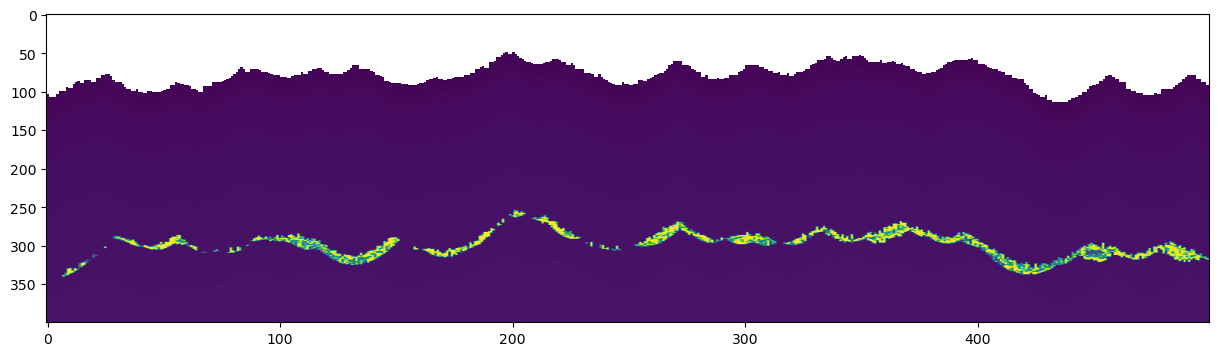

In [57]:
plt.figure(figsize=(15,4))
plt.imshow(velmodel[:,200,:].T, aspect="auto")
plt.show()

# OLD

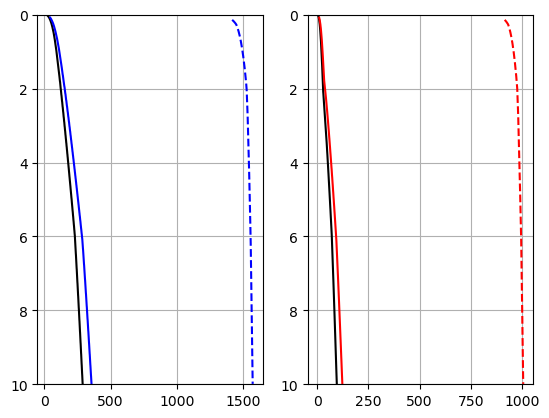

In [20]:
"""
Create 1D velocity models 

CONSIDERATIONS TO FOLLOW UP
-should ice be pore-filling? my measurements don't jive with that
-looks like porosity is increased by ~3% at 20 wt% ice

"""

##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES

## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Specific gravity of regolith
sg_low = 2.9
sg_high = 3.24

## Depth range, in m
max_depth = 10
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equations from Lunar Sourcebook, in g/cm3, page 494
## Assume 5% error for lows and highs calculations
dens_err = 0.05
densities_hyp = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))   #hyperbolic function
densities_pow = 1.39*(depths*100)**0.056
dens_stk = np.vstack((densities_hyp, densities_pow))
dens_low = np.amin(dens_stk, axis=0) * (1-dens_err)
dens_high = np.amax(dens_stk, axis=0) * (1+dens_err)

## Calculate porosity low and high
por_low = 1 - (dens_high / sg_low)
por_high = 1 - (dens_low / sg_high)


## Pressure, in MPa
integrated_density_low = integrate.cumulative_trapezoid(dens_low)
integrated_density_high = integrate.cumulative_trapezoid(dens_high)
ss_pressures_low = np.cumsum((grav_accel * integrated_density_low * depth_step) / 1e6)
ss_pressures_low = np.hstack((0, ss_pressures_low))
ss_pressures_high = np.cumsum((grav_accel * integrated_density_high * depth_step) / 1e6)
ss_pressures_high = np.hstack((0, ss_pressures_high))
ss_pressures_avg = np.mean((ss_pressures_low, ss_pressures_high), axis=0)


##---------------
## Make icy 1D profile

## Porosity increase due to granular ice
_por_inc = [0, 0.03]
_ice_perc = [0, ice_percs_vol[-1]]
ice_por_inc_fit = np.poly1d(np.polyfit(_ice_perc, _por_inc, deg=1))

## Ice profile
ice_amt = ice_percs_vol[1]
ice_profile = np.full(depths.shape, ice_amt)
por_inc = ice_por_inc_fit(ice_profile)

## Icy density profiles
## Just assume reg density of 3 and ice 0.92
dens_diff = 0.92/3
ice_sg_low = 2.9 - (dens_diff*ice_amt*2.9)
ice_sg_high = 3.24 - (dens_diff*ice_amt*3.24)
ice_dens_low = dens_low - (dens_diff*ice_amt*dens_low)
ice_dens_high = dens_high - (dens_diff*ice_amt*dens_high)

## Calculate porosity low and high
ice_por_low = (1 - (ice_dens_high / ice_sg_low)) + por_inc
ice_por_high = (1 - (ice_dens_low / ice_sg_high)) + por_inc

## Pressure, in MPa
ice_integrated_density_low = integrate.cumulative_trapezoid(ice_dens_low)
ice_integrated_density_high = integrate.cumulative_trapezoid(ice_dens_high)
ice_ss_pressures_low = np.cumsum((grav_accel * ice_integrated_density_low * depth_step) / 1e6)
ice_ss_pressures_low = np.hstack((0, ice_ss_pressures_low))
ice_ss_pressures_high = np.cumsum((grav_accel * ice_integrated_density_high * depth_step) / 1e6)
ice_ss_pressures_high = np.hstack((0, ice_ss_pressures_high))
ice_ss_pressures_avg = np.mean((ice_ss_pressures_low, ice_ss_pressures_high), axis=0)


vp_amos_dry = []
vs_amos_dry = []
vp_amos_ice = []
vs_amos_ice = []
vp_amos_cem = []
vs_amos_cem = []

for por, pressure in zip(por_high, ss_pressures_low):
    if pressure==0:
        continue
    ## Change pressure to GPa
    pressure = pressure/1000

    C = 3
    dens = eff_min_density*(1-por)

    ## poisson's ratio
    pr = pr_pres_fit(pressure**(1/10))
    if pr > 0.49:
        pr=0.49
    # pr=0.4

    ## Estimate a contact ratio based on pressure
    if pressure <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(0.1, contact_ratios[0], 100) #0.4 used to be 0.25
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < pressure <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                            critical_porosity, C, pressure, 
                                            c_ratio=contact_ratio, slip_percent=slip_percent)

    k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                         por=por, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="soft", mix_amount=0)
    try:
        vp_amos_dry.append(rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000)
        vs_amos_dry.append(rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000)
    except IndexError:
        vp_amos_dry.append(np.nan)
        vs_amos_dry.append(np.nan)

for por, pressure, ice_perc in zip(ice_por_high, ice_ss_pressures_low, ice_profile):
    if pressure==0:
        continue
    ## Change pressure to GPa
    pressure = pressure/1000

    C = 3

    ## Adjust PR based on pressure, then adjust based on ice content
    p_pres = pr_pres_fit(pressure**(1/10))
    if ice_perc == 0:
        pr = p_pres
    else:
        pr = pr_ice_fit(p_pres, ice_perc)
    if pr > 0.49:
        pr=0.49

    # Use function to determine effective cement
    if ice_perc == 0:
        eff_cem = 0
    else:
        eff_cem = eff_cem_fit_func(ice_perc, *eff_cem_fit_parms)
        if eff_cem > 1:
            eff_cem = 0

    ## Estimate a contact ratio based on pressure
    if pressure <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(0.1, contact_ratios[0], 100) #0.4 used to be 0.25
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < pressure <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                            critical_porosity, C, pressure, 
                                            c_ratio=contact_ratio, slip_percent=slip_percent)

    ## GRANULAR
    ## Account for "effective cement"
    mix_amount = ice_perc * eff_cem * 10
    
    k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                         por=por, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="soft", mix_amount=mix_amount)
    try:
        vp_amos_ice.append(rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000)
        vs_amos_ice.append(rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000)
    except IndexError:
        vp_amos_ice.append(np.nan)
        vs_amos_ice.append(np.nan)

    ## CEMENTED
    ## Account for "effective cement"
    mix_amount = ice_perc * eff_cemented_cem * 10
    if mix_amount > 1.:
        mix_amount = 1.
    
    k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                         por=por, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="stiff", mix_amount=mix_amount)
    try:
        vp_amos_cem.append(rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000)
        vs_amos_cem.append(rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000)
    except IndexError:
        vp_amos_cem.append(np.nan)
        vs_amos_cem.append(np.nan)


vp_amos_dry = np.hstack((np.nan, np.array(vp_amos_dry)))
vs_amos_dry = np.hstack((np.nan, np.array(vs_amos_dry)))
vp_amos_ice = np.hstack((np.nan, np.array(vp_amos_ice)))
vs_amos_ice = np.hstack((np.nan, np.array(vs_amos_ice)))
vp_amos_cem = np.hstack((np.nan, np.array(vp_amos_cem)))
vs_amos_cem = np.hstack((np.nan, np.array(vs_amos_cem)))



fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(vp_amos_dry, depths, color="black")
ax[0].plot(vp_amos_ice, depths, color="blue")
ax[0].plot(vp_amos_cem, depths, color="blue", ls="--")
ax[0].set_ylim(10,0)
ax[0].grid("both")

ax[1].plot(vs_amos_dry, depths, color="black")
ax[1].plot(vs_amos_ice, depths, color="red")
ax[1].plot(vs_amos_cem, depths, color="red", ls="--")
ax[1].set_ylim(10,0)
ax[1].grid("both")

plt.show()

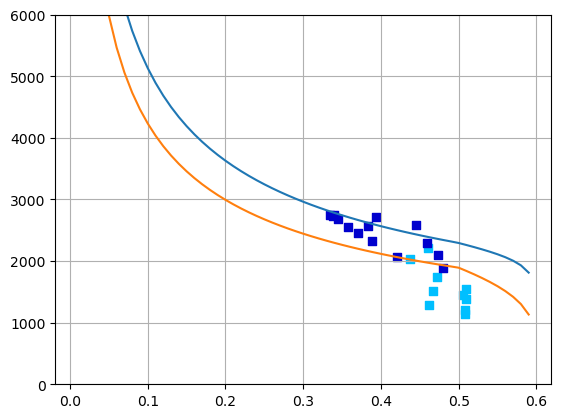

In [4]:
# ## effective mineral moduli with 10% ice
# icy_eff_min_k = rp.hill_average([0.9, 0.1], [effective_mineral_k, ice_k])
# icy_eff_min_u = rp.hill_average([0.9, 0.1], [effective_mineral_u, ice_u])

cement = 0.1
critical_por = 0.6


## moduli at transition from cementing to pore filling
# trans_k, trans_u = rp.cemented_model(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   por=critical_por-cement, crit_por=critical_por, C = rp.upper_murphy(critical_por-cement), scheme="uniform")


# ## use lower HS to calculate pore filling moduli, followed by cemented model
# por_range = np.arange(0,critical_por+0.01, 0.01)
# k_range, u_range = [], []
# pvels = []
# for por in por_range:
#     if por < (critical_por-cement):
#         k, u = rp.uncemented_model(por, critical_por-cement, trans_k, trans_u, icy_eff_min_k, icy_eff_min_u)
#         k_range.append(k)
#         u_range.append(u)
#     else:
#         k, u = rp.cemented_model(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   por, crit_por=critical_por, C=rp.upper_murphy(por), scheme="uniform")
#         k_range.append(k)
#         u_range.append(u)

#     pvels.append(rp.p_vel_mod(k, u, eff_min_density)*1000)


# plt.figure()
# plt.plot(por_range, pvels)
# plt.grid("both")
# # plt.ylim(0, 3000)
# plt.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", 
#               color=ice_colors[1], marker="s")
# plt.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", 
#               color=ice_colors[2], marker="s")
# plt.show()



# cem_k, cem_u = [], []
# for por in por_range:
#     k, u = rp.cemented_model(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   por, crit_por=0.6, C=3, scheme="contact")
#     cem_k.append(k)
#     cem_u.append(u)

# plt.figure()
# plt.plot(por_range, cem_k)
# plt.plot(por_range, cem_u)
# plt.show()



k_sccem, u_sccem, por_sccem = rp.self_consistent_contact_cement(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
                  por=critical_por-cement, crit_por=critical_por, C=3, scheme="contact")
k_sccem_uni, u_sccem_uni, por_sccem_uni = rp.self_consistent_contact_cement(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
                  por=critical_por-cement, crit_por=critical_por, C=3, scheme="uniform")
# k_sccem, u_sccem, por_sccem = rp.self_consistent_contact_cement_SYM(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   critical_por-cement, critical_por, C=5, scheme="contact")

vp_sccem = rp.p_vel_mod(k_sccem, u_sccem, eff_min_density*por_sccem)*1000
vs_sccem = rp.s_vel_mod(u_sccem, eff_min_density*por_sccem)*1000

vp_sccem_uni = rp.p_vel_mod(k_sccem_uni, u_sccem_uni, eff_min_density*por_sccem_uni)*1000

plt.figure()
plt.plot(por_sccem, vp_sccem)
plt.plot(por_sccem_uni, vp_sccem_uni)
# plt.plot(por_sccem, vs_sccem)
dot_size = 30
plt.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", 
              color=ice_colors[1], marker="s")
plt.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", 
              color=ice_colors[2], marker="s")
plt.ylim(0, 6000)
plt.grid("both")
plt.show()

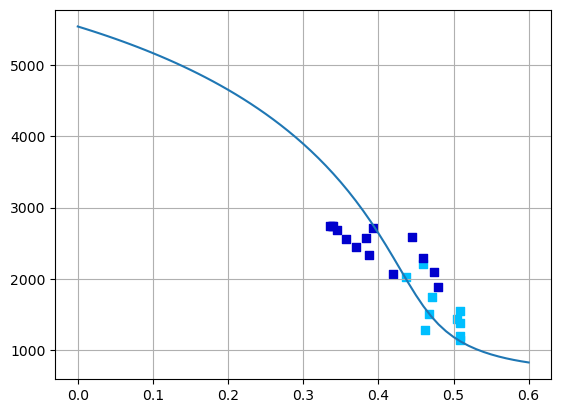

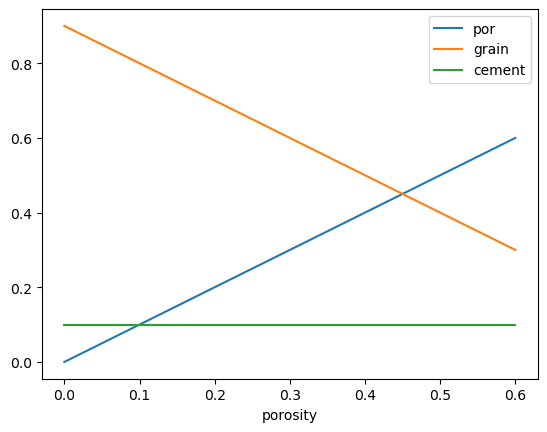

In [38]:
"""
berryman tests
"""
#-------------------------------------
## functions
from sympy import symbols, Eq, solve, nsolve, solveset, S
def z_var(k, u):
    z = (u*(9*k + 8*u)) / (6*(k + 2*u))
    return z
def b_var(k,u):
    b = u * ((3*k + u)/(3*k + 4*u))
    return b
def q_var(ki, ui, km, um, shape, aspect_ratio):
    if shape.lower()=='spheres':
        q = (um + z_var(km, um)) / (ui + z_var(km, um))
    if shape.lower()=='disks':
        q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))
    if shape.lower()=='penny cracks':
        q = (1/5) * (1 + (8*um / (4*ui + np.pi*aspect_ratio*(um + 2*b_var(km, um)))) + \
                     2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*aspect_ratio*b_var(km, um))))
    return q
def p_var(ki, ui, km, um, shape, aspect_ratio):
    
    if shape.lower()=='spheres':
        p = (km + (4/3)*um) / (ki + (4/3)*um)
    if shape.lower()=='disks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui)
    if shape.lower()=='penny cracks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*aspect_ratio*b_var(km, um))
    return p



#-------------------------------------



k_list = [effective_mineral_k, ice_k, 0.]
mu_list = [effective_mineral_u, ice_u, 0.]
# vol_fracts = [0.45, 0.05, 0.5]
# vol_fracts = [0.55, 0.1, 0.35]
# vol_fracts = [0.55, 0.45, 0.]
inclusion_shapes = ["spheres", "disks", "spheres"]
crack_aspect_ratios = [1, 1e-2, 1]

critical_porosity = 0.6
cement = 0.1
por_range = np.arange(0, critical_porosity+0.01, 0.01)
grain_range = np.arange(1, 1-(critical_porosity+0.01), -0.01) - cement
cem_range = np.array([cement]*len(grain_range)) 

vp_sc, vs_sc = [], []

for i in range(len(por_range)):
    v_grain = grain_range[i]
    v_por = por_range[i]
    v_ice = cem_range[i]
    vol_fracts = [v_grain, v_ice, v_por]

    ksc, usc = symbols('ksc usc', positive=True, real=True)
    k_start = k_list[0]*vol_fracts[0]
    u_start = mu_list[0]*vol_fracts[0]
    
    eqk = Eq((
        (vol_fracts[0] * (k_list[0] - ksc) * p_var(k_list[0], mu_list[0], ksc, usc, 
                                                   inclusion_shapes[0], crack_aspect_ratios[0]))+
        (vol_fracts[1] * (k_list[1] - ksc) * p_var(k_list[1], mu_list[1], ksc, usc, 
                                                   inclusion_shapes[1], crack_aspect_ratios[1]))+
        (vol_fracts[2] * (k_list[2] - ksc) * p_var(k_list[2], mu_list[2], ksc, usc, 
                                                   inclusion_shapes[2], crack_aspect_ratios[2]))),0)
    equ = Eq((
        (vol_fracts[0] * (mu_list[0] - usc) * q_var(k_list[0], mu_list[0], ksc, usc, 
                                                   inclusion_shapes[0], crack_aspect_ratios[0]))+
        (vol_fracts[1] * (mu_list[1] - usc) * q_var(k_list[1], mu_list[1], ksc, usc, 
                                                   inclusion_shapes[1], crack_aspect_ratios[1]))+
        (vol_fracts[2] * (mu_list[2] - usc) * q_var(k_list[2], mu_list[2], ksc, usc, 
                                                   inclusion_shapes[2], crack_aspect_ratios[2]))),0)

    iter_solve_k, iter_solve_u = nsolve((eqk, equ), (ksc, usc), (k_start, u_start))
    tmp_vp = rp.p_vel_mod(iter_solve_k, iter_solve_u, eff_min_density*(1-v_por))*1000
    tmp_vs = rp.s_vel_mod(iter_solve_u, eff_min_density*(1-v_por))*1000
    vp_sc.append(tmp_vp)
    vs_sc.append(tmp_vs)


# iter_solve_k, iter_solve_u = nsolve((eqk, equ), (ksc, usc), (k_start, u_start))
# print(iter_solve_k, iter_solve_u)
# p_vel = rp.p_vel_mod(iter_solve_k, iter_solve_u, eff_min_density*0.6)
# print("Spheres P vel: ", round(p_vel*1000))

dot_size=30
plt.plot(por_range, vp_sc)
plt.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s")
plt.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, 
              color=ice_colors[2], marker="s")
plt.grid("both")
plt.show()



plt.plot(por_range, por_range, label="por")
plt.plot(por_range, grain_range, label="grain")
plt.plot(por_range, cem_range, label="cement")
plt.legend()
plt.xlabel("porosity")
plt.show()

In [53]:
def berryman_sca(k_list, mu_list, vol_fracts, inclusion_shapes,
                  crack_aspect_ratios=[]):

    assert len(k_list)==len(mu_list)==len(vol_fracts)==len(inclusion_shapes),\
        "Length of input variables is not consistent"

    allowable_inclusions = ['spheres', 'disks', 'penny cracks']
    inclusion_shapes = [i.lower() for i in inclusion_shapes]
    for i in inclusion_shapes:
        assert i in allowable_inclusions, "Inclusion shape not supported"

    if "penny cracks" in inclusion_shapes:
        assert len(crack_aspect_ratios) != 0, "Penny cracks must include aspect ratio"
        # crack_count = inclusion_shapes.lower().count("penny cracks")
        # assert len(crack_aspect_ratios)==len(k_list) or len(crack_aspect_ratios)==crack_count,\
        #     "Check aspect ratios: Penny cracks must include aspect ratio"
        assert len(crack_aspect_ratios)==len(k_list), \
            "If providing penny cracks, use aspect ratio of 1 or np.nan for non-cracks"

    ## create dummy list even if no penny cracks
    if "penny cracks" not in inclusion_shapes:
        crack_aspect_ratios = [1] * len(k_list)


    ## Helper functions for P and Q coefficients
    ## RP handbook, page 187
    def z_var(k, u):
        z = (u*(9*k + 8*u)) / (6*(k + 2*u))
        return z
    
    def b_var(k,u):
        b = u * ((3*k + u)/(3*k + 4*u))
        return b

    def q_var(ki, ui, km, um, shape, aspect_ratio):
        
        if shape.lower()=='spheres':
            q = (um + z_var(km, um)) / (ui + z_var(km, um))
        if shape.lower()=='disks':
            q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))
        if shape.lower()=='penny cracks':
            q = (1/5) * (1 + (8*um / (4*ui + np.pi*aspect_ratio*(um + 2*b_var(km, um)))) + \
                         2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*aspect_ratio*b_var(km, um))))
        return q

    def p_var(ki, ui, km, um, shape, aspect_ratio):
        
        if shape.lower()=='spheres':
            p = (km + (4/3)*um) / (ki + (4/3)*um)
        if shape.lower()=='disks':
            p = (km + (4/3)*ui) / (ki + (4/3)*ui)
        if shape.lower()=='penny cracks':
            p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*aspect_ratio*b_var(km, um))
        return p
    

    ## Calculate starting point using Voight average
    kvoight = rp.voight_average(vol_fracts, k_list)
    uvoight = rp.voight_average(vol_fracts, mu_list)
    kreuss = rp.reuss_average(vol_fracts, k_list)
    ureuss = rp.reuss_average(vol_fracts, mu_list)
    # ksc, usc = kvoight, uvoight
    # ksc, usc = k_list[0]*vol_fracts[0], mu_list[0]*vol_fracts[0]
    ksc, usc = k_list[0], mu_list[0]
    kold, uold = 0, 0

    ## set the error tolerance
    # err_tolerance = 1e-6*k_list[0]
    err_tolerance = 1e-4*k_list[0]



    plt_k, plt_u = [], []

    

    iter_count=0
    while np.abs(ksc-kold)>err_tolerance: 
        # while (np.abs(ksc-kold)>err_tolerance) and (np.abs(usc-uold)>err_tolerance): 
        kold = ksc
        uold = usc

        p_vars = []
        for k, u, shape, aspect_ratio in zip(k_list, mu_list, inclusion_shapes, crack_aspect_ratios):
            tmp_p = p_var(k, u, ksc, usc, shape, aspect_ratio)
            p_vars.append(tmp_p)
        q_vars = []
        for k, u, shape, aspect_ratio in zip(k_list, mu_list, inclusion_shapes, crack_aspect_ratios):
            tmp_q = q_var(k, u, ksc, usc, shape, aspect_ratio)
            q_vars.append(tmp_q)

        ## i don't know what to do here
        ## the "denom" is following stanford matlab code
        k_tmp = []
        k_denom = []
        for i in range(len(vol_fracts)):
            _k = vol_fracts[i] * (k_list[i] - ksc) * p_vars[i]
            k_tmp.append(_k)
            _kd = vol_fracts[i]* p_vars[i]
            k_denom.append(_kd)
        u_tmp = []
        u_denom = []
        for i in range(len(vol_fracts)):
            _u = vol_fracts[i] * (mu_list[i] - usc) * q_vars[i]
            u_tmp.append(_u)
            _ud = vol_fracts[i] * q_vars[i]
            u_denom.append(_ud)

        # ksc = ksc - np.sum(k_tmp)
        # usc = usc - np.sum(u_tmp)
        ksc = np.sum(k_tmp) / np.sum(k_denom)
        usc = np.sum(u_tmp) / np.sum(u_denom)

        if ksc > max(kvoight, kreuss):
            ksc = max(kvoight, kreuss)
        if ksc < min(kvoight, kreuss):
            ksc = min(kvoight, kreuss)
        if usc > max(uvoight, ureuss):
            usc = max(uvoight, ureuss)
        if usc < min(uvoight, ureuss):
            usc = min(uvoight, ureuss)



        plt_k.append(ksc)
        plt_u.append(usc)

        

        
        ## kill process if iterations don't converge after set number
        iter_count+=1
        if iter_count == 10000:


            plt.plot(np.arange(iter_count), plt_k, label="k")
            plt.plot(np.arange(iter_count), plt_u, label="u")
            plt.legend()
            plt.show()

            
            # sys.stdout.write("Berryman SCA could not converge")
            print("Berryman SCA could not converge")
            return
    
    
    # print(iter_count)
    plt.plot(np.arange(iter_count), plt_k, label="k")
    plt.plot(np.arange(iter_count), plt_u, label="u")
    plt.legend()
    plt.show()



    
    return ksc, usc



k_list = [37, 2.25, 2.25]
mu_list = [44, 0., 0.]
vol_fracts = [0.7, 0.29, 0.01]
inclusion_shapes = ["spheres", "spheres", "penny cracks"]
crack_aspect_ratios = [1, 1, 10e-2]


# k_list = [37, 0]
# mu_list = [44, 0]
# vol_fracts = [0.7, 0.3]
# inclusion_shapes = ["spheres", "spheres"]

k, u = berryman_sca(k_list, mu_list, vol_fracts, inclusion_shapes, crack_aspect_ratios)
print(k, u)

ZeroDivisionError: float division by zero

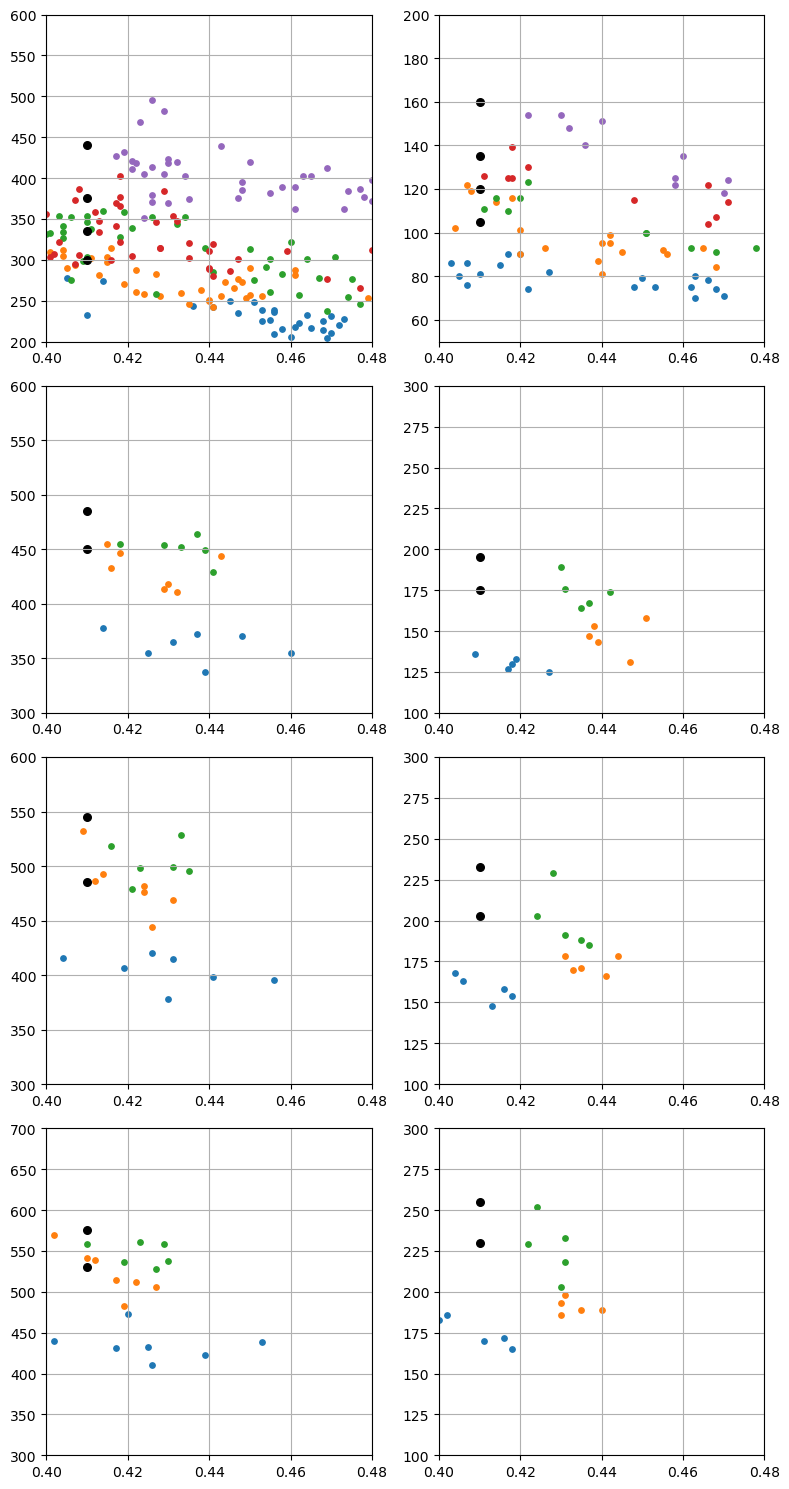

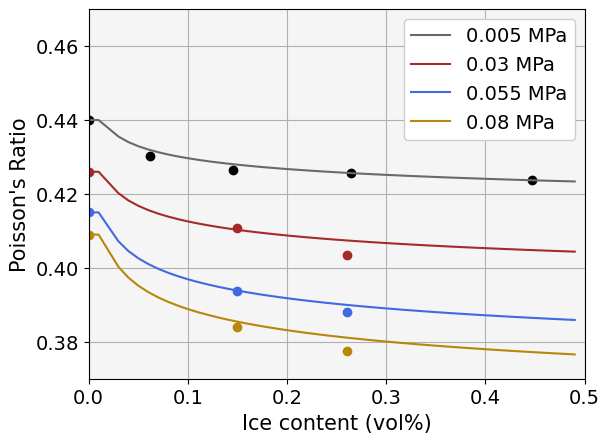

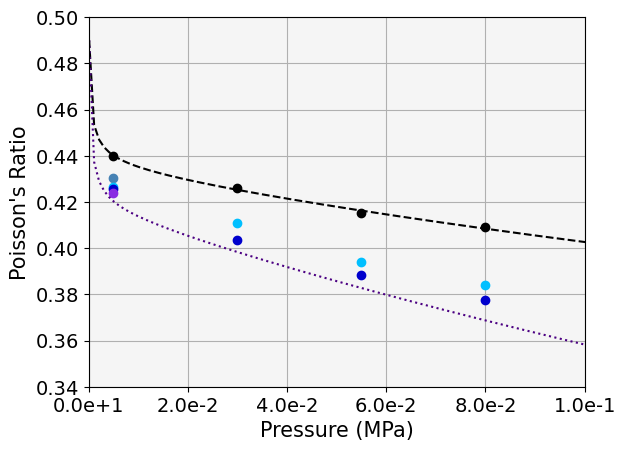

In [44]:
"""
How does ice and pressure affect Poisson's Ratio?
"""

#-----------
## Manually pick velocity at the fitting porosity (~41%)
fit_vp_p0 = [300, 335, 375, 440]
fit_vs_p0 = [105, 120, 135, 160]

fit_vp_p1 = [450, 485]
fit_vs_p1 = [175, 195]

fit_vp_p2 = [485, 545]
fit_vs_p2 = [203, 233]

fit_vp_p3 = [530, 575]
fit_vs_p3 = [230, 255]

tmp_ice_percs_vol_p0 = [0] + ice_percs_vol
tmp_ice_percs_vol_multiP = [0, 0.15, 0.26]



#------------------
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,15))
dot_size=15

ax[0,0].scatter(data_p_0i[:,2], data_p_0i[:,0], s=dot_size)
ax[0,0].scatter(data_p_2i[:,2], data_p_2i[:,0], s=dot_size)
ax[0,0].scatter(data_p_5i[:,2], data_p_5i[:,0], s=dot_size)
ax[0,0].scatter(data_p_10i[:,2], data_p_10i[:,0], s=dot_size)
ax[0,0].scatter(data_p_20i[:,2], data_p_20i[:,0], s=dot_size)
ax[0,0].set(ylim=(200,600),
           xlim=(0.4, 0.48))
ax[0,0].grid("both")
for p in fit_vp_p0:
    ax[0,0].scatter(0.41, p, s=dot_size*2, c="black")

ax[0,1].scatter(data_s_0i[:,2], data_s_0i[:,0], s=dot_size)
ax[0,1].scatter(data_s_2i[:,2], data_s_2i[:,0], s=dot_size)
ax[0,1].scatter(data_s_5i[:,2], data_s_5i[:,0], s=dot_size)
ax[0,1].scatter(data_s_10i[:,2], data_s_10i[:,0], s=dot_size)
ax[0,1].scatter(data_s_20i[:,2], data_s_20i[:,0], s=dot_size)
ax[0,1].set(ylim=(50,200),
           xlim=(0.4, 0.48))
ax[0,1].grid("both")
for s in fit_vs_p0:
    ax[0,1].scatter(0.41, s, s=dot_size*2, c="black")

ax[1,0].scatter(pres_step_1_p_0i[:,2], pres_step_1_p_0i[:,0], s=dot_size)
ax[1,0].scatter(pres_step_1_p_5i[:,2], pres_step_1_p_5i[:,0], s=dot_size)
ax[1,0].scatter(pres_step_1_p_10i[:,2], pres_step_1_p_10i[:,0], s=dot_size)
ax[1,0].set(ylim=(300,600),
           xlim=(0.4, 0.48))
ax[1,0].grid("both")
for p in fit_vp_p1:
    ax[1,0].scatter(0.41, p, s=dot_size*2, c="black")

ax[1,1].scatter(pres_step_1_s_0i[:,2], pres_step_1_s_0i[:,0], s=dot_size)
ax[1,1].scatter(pres_step_1_s_5i[:,2], pres_step_1_s_5i[:,0], s=dot_size)
ax[1,1].scatter(pres_step_1_s_10i[:,2], pres_step_1_s_10i[:,0], s=dot_size)
ax[1,1].set(ylim=(100,300),
           xlim=(0.4, 0.48))
ax[1,1].grid("both")
for s in fit_vs_p1:
    ax[1,1].scatter(0.41, s, s=dot_size*2, c="black")


ax[2,0].scatter(pres_step_2_p_0i[:,2], pres_step_2_p_0i[:,0], s=dot_size)
ax[2,0].scatter(pres_step_2_p_5i[:,2], pres_step_2_p_5i[:,0], s=dot_size)
ax[2,0].scatter(pres_step_2_p_10i[:,2], pres_step_2_p_10i[:,0], s=dot_size)
ax[2,0].set(ylim=(300,600),
           xlim=(0.4, 0.48))
ax[2,0].grid("both")
for p in fit_vp_p2:
    ax[2,0].scatter(0.41, p, s=dot_size*2, c="black")

ax[2,1].scatter(pres_step_2_s_0i[:,2], pres_step_2_s_0i[:,0], s=dot_size)
ax[2,1].scatter(pres_step_2_s_5i[:,2], pres_step_2_s_5i[:,0], s=dot_size)
ax[2,1].scatter(pres_step_2_s_10i[:,2], pres_step_2_s_10i[:,0], s=dot_size)
ax[2,1].set(ylim=(100,300),
           xlim=(0.4, 0.48))
ax[2,1].grid("both")
for s in fit_vs_p2:
    ax[2,1].scatter(0.41, s, s=dot_size*2, c="black")


ax[3,0].scatter(pres_step_3_p_0i[:,2], pres_step_3_p_0i[:,0], s=dot_size)
ax[3,0].scatter(pres_step_3_p_5i[:,2], pres_step_3_p_5i[:,0], s=dot_size)
ax[3,0].scatter(pres_step_3_p_10i[:,2], pres_step_3_p_10i[:,0], s=dot_size)
ax[3,0].set(ylim=(300,700),
           xlim=(0.4, 0.48))
ax[3,0].grid("both")
for p in fit_vp_p3:
    ax[3,0].scatter(0.41, p, s=dot_size*2, c="black")

ax[3,1].scatter(pres_step_3_s_0i[:,2], pres_step_3_s_0i[:,0], s=dot_size)
ax[3,1].scatter(pres_step_3_s_5i[:,2], pres_step_3_s_5i[:,0], s=dot_size)
ax[3,1].scatter(pres_step_3_s_10i[:,2], pres_step_3_s_10i[:,0], s=dot_size)
ax[3,1].set(ylim=(100,300),
           xlim=(0.4, 0.48))
ax[3,1].grid("both")
for s in fit_vs_p3:
    ax[3,1].scatter(0.41, s, s=dot_size*2, c="black")

plt.tight_layout()
plt.show()
#------------------

# Stack the PR values from icy fits for each pressure step
pr_ice_p0 = [rp.elastic.poisson_vel(p, s) for p, s in zip(fit_vp_p0, fit_vs_p0)]
pr_ice_p0 = [max_poisson_list[0]] + pr_ice_p0
pr_ice_p1 = [rp.elastic.poisson_vel(p, s) for p, s in zip(fit_vp_p1, fit_vs_p1)]
pr_ice_p1 = [max_poisson_list[1]] + pr_ice_p1
pr_ice_p2 = [rp.elastic.poisson_vel(p, s) for p, s in zip(fit_vp_p2, fit_vs_p2)]
pr_ice_p2 = [max_poisson_list[2]] + pr_ice_p2
pr_ice_p3 = [rp.elastic.poisson_vel(p, s) for p, s in zip(fit_vp_p3, fit_vs_p3)]
pr_ice_p3 = [max_poisson_list[3]] + pr_ice_p3


##------------------------------------------
##------------------------------------------
## DEFINE PR FITS VERSUS ICE AND PRESSURE

def pr_ice_fit(ice_perc, max_poisson, min_poisson):
    if ice_perc == 0:
        pr = max_poisson
    else:
        ## This factor controls how the fitting PR will vary with ice content
        # factor = 1 / ice_perc**0.15-1  #close
        factor = 1.05 / ice_perc**0.15-1
        # factor = 1.2 / ice_perc**0.17-1

        
        pr = (factor * max_poisson) + ((1-factor) * min_poisson)
    if pr > max_poisson:
        pr = max_poisson
    return pr

pres_range = np.linspace(0.0000001,0.0005, 500)
## Perform polynomial fit to average PR values from measurements
## Add near-intercept point to control fit
_fitpres = np.insert(pressures, 0, 0.0000001)
_fitpr = np.insert(max_poisson_list, 0, 0.49) 
pr_fit_max = np.poly1d(np.polyfit(_fitpres**(1/10), _fitpr, deg=3))
est_pr_max = []
for p in pres_range:
    est_pr_max.append(pr_fit_max(p**(1/10)))
_fitpr = np.insert(min_poisson_list, 0, 0.49) 
pr_fit_min = np.poly1d(np.polyfit(_fitpres**(1/10), _fitpr, deg=3))
est_pr_min = []
for p in pres_range:
    est_pr_min.append(pr_fit_min(p**(1/10)))

##------------------------------------------
##------------------------------------------


curve_ice_vol = np.arange(0, 0.5, 0.01)
pr_curve_p0 = []
pr_curve_p1 = []
pr_curve_p2 = []
pr_curve_p3 = []
for i in curve_ice_vol:
    pr_curve_p0.append(pr_ice_fit(i, max_poisson=max_poisson_list[0], min_poisson=min_poisson_list[0]))
    pr_curve_p1.append(pr_ice_fit(i, max_poisson=max_poisson_list[1], min_poisson=min_poisson_list[1]))
    pr_curve_p2.append(pr_ice_fit(i, max_poisson=max_poisson_list[2], min_poisson=min_poisson_list[2]))
    pr_curve_p3.append(pr_ice_fit(i, max_poisson=max_poisson_list[3], min_poisson=min_poisson_list[3]))

plt.plot(curve_ice_vol, pr_curve_p0, color=pres_colors[0], label=str(round(pressures[0]*1000,3))+" MPa")
plt.plot(curve_ice_vol, pr_curve_p1, color=pres_colors[1], label=str(round(pressures[1]*1000,3))+" MPa")
plt.plot(curve_ice_vol, pr_curve_p2, color=pres_colors[2], label=str(round(pressures[2]*1000,3))+" MPa")
plt.plot(curve_ice_vol, pr_curve_p3, color=pres_colors[3], label=str(round(pressures[3]*1000,3))+" MPa")
plt.scatter(tmp_ice_percs_vol_p0, pr_ice_p0, c="black")
plt.scatter(tmp_ice_percs_vol_multiP, pr_ice_p1, c=pres_colors[1])
plt.scatter(tmp_ice_percs_vol_multiP, pr_ice_p2, c=pres_colors[2])
plt.scatter(tmp_ice_percs_vol_multiP, pr_ice_p3, c=pres_colors[3])
plt.gca().set(xlim=(0, 0.5),
         ylim=(0.37,0.47),
         axisbelow=True,
         facecolor="whitesmoke")
plt.xlabel("Ice content (vol%)", fontsize=15)
plt.ylabel("Poisson's Ratio", fontsize=15)
plt.tick_params(axis='both', labelsize=14)
plt.grid("both")
plt.legend(fontsize=14, framealpha=1)
plt.show()

for i, pr in enumerate(pr_ice_p0):
    if i == 0:
        plt.scatter(pressures[0]*1000, pr, c="black")
    else:
        i = i-1
        plt.scatter(pressures[0]*1000, pr, c=ice_colors[i])
for i in range(len(pr_ice_p1)):
    if i == 0:
        plt.scatter(pressures[1]*1000, pr_ice_p1[i], c="black")
        plt.scatter(pressures[2]*1000, pr_ice_p2[i], c="black")
        plt.scatter(pressures[3]*1000, pr_ice_p3[i], c="black")
    else:
        plt.scatter(pressures[1]*1000, pr_ice_p1[i], c=ice_colors[i])
        plt.scatter(pressures[2]*1000, pr_ice_p2[i], c=ice_colors[i])
        plt.scatter(pressures[3]*1000, pr_ice_p3[i], c=ice_colors[i])
    
plt.plot(pres_range*1000, est_pr_max, color="black", ls="--")
plt.plot(pres_range*1000, est_pr_min, color="indigo", ls=":")
plt.gca().set(ylim = (0.34, 0.5),
              # xlim=(0, pres_range[-1]*1000),
              xlim=(0, 1.e-1),
              axisbelow=True,
              facecolor="whitesmoke")  
plt.gca().xaxis.set_major_formatter(major_formatter2)
plt.xlabel("Pressure (MPa)", fontsize=15)
plt.ylabel("Poisson's Ratio", fontsize=15)
plt.tick_params(axis='both', labelsize=14)
plt.grid("both")

##TEST
# test_pres = 0.00008
# test_ice = 0.15
# p_max = pr_fit_max(test_pres**(1/10))
# p_min = pr_fit_min(test_pres**(1/10))
# pr_test = pr_ice_fit(test_ice, p_max, p_min)
# plt.scatter(test_pres*1000, pr_test, c="red", s=dot_size*2)

plt.show()